# Plots and Statistics in the Paper

## Global functions and imports

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import argrelmax, argrelmin
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
from tqdm import tqdm, trange
import load_pe
import h5py
import glob
import pandas as pd
from gwpopulation.models.mass import SinglePeakSmoothedMassDistribution
from bilby.hyper.model import Model

plt.rcParams.update( {'font.size': 24, 'font.family':'serif', 'axes.labelsize':24, 
                      'axes.titlesize':24, 'legend.fontsize':20, 'text.usetex':True} )

In [2]:
def load_result_json(json_file):
    f = open(json_file)
  
    # returns JSON object as 
    # a dictionary
    data = json.load(f)

    posterior = data['posterior']['content']

    # Closing file
    f.close()
    
    return posterior

mgrid = np.linspace(2,100,1000)
def get_perturbation(filename, num_knots=20, exclude_mmin_mmax=True):
    post = load_result_json(filename)
    num_samples = len(post['m1'])
    spls = np.zeros((num_samples,len(mgrid)))
    m_spls = [post[f"m{j}"][0] for j in range(num_knots)]
    sel = (mgrid >= m_spls[0]) & (mgrid <= m_spls[-1])
    for i in range(num_samples):
        f_spls = [post[f"f{j}"][i] for j in range(num_knots)]
        interp = interp1d(np.log(m_spls), f_spls, kind='cubic', bounds_error=False, fill_value=0)
        if exclude_mmin_mmax:
            sel_i = sel & (mgrid >= post['mmin'][i]) & (mgrid <= post['mmax'][i])
        else:
            sel_i = sel
        spls[i]=np.where(sel_i,interp(np.log(mgrid)),0)
    return np.array(spls), mgrid

## Load in data

### Spline Runs

In [3]:
# PS runs on mock catalogs
mock_run_path = 'Dec12/'
fnames = glob.glob(mock_run_path+'PowerLawSpline_69evs_20knots_2t100_*')
# fnames = glob.glob(mock_run_path+'PS_zevo_split_PEfmt_20knots_3t200_cut_*json')
num_mock_catalogs = len(fnames)
num_knots = 20

perturbation_functions = dict()
for run, fname in tqdm(enumerate(fnames), total=num_mock_catalogs):
    try:
        perturbation_functions[f'run_{run}'], ms = get_perturbation(fname,exclude_mmin_mmax=False)
    except UnicodeDecodeError:
        print(fname)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [08:23<00:00,  1.67s/it]


In [8]:
# PS run on GWTC-3
gwtc_3_result_file = "spline_20n_mass_m_iid_mag_iid_tilt_powerlaw_redshift_result.json"
#"GWTC-3-population-data/"\
#"analyses/PowerLawSpline/o1o2o3/spline_20n_mass_m_iid_mag_iid_tilt_powerlaw_redshift_result.json"
# '/home/daniel.wysocki/o3b-population-data/'
num_knots = 20

gwtc_3_pert, ms = get_perturbation(gwtc_3_result_file,exclude_mmin_mmax=False)
posterior_gwtc_3 = load_result_json(gwtc_3_result_file)
f_spls_gwtc3 = np.array([posterior_gwtc_3[f"f{k}"] for k in range(num_knots)]).T
m_spls_gwtc3 = np.array([posterior_gwtc_3[f"m{k}"][0] for k in range(num_knots)])

### Catalog

In [4]:
# GWTC-3 BBHs
# If on CIT, use the following paths: 
# /home/amanda.farah/PE_sample_mirror/GWTC-3/*nocosmo*h5
# /home/amanda.farah/PE_sample_mirror/GWTC-2.1/*nocosmo*h5
# /home/amanda.farah/PE_sample_mirror/gwosc_download_gwtc3.csv
all_bbhs=load_pe.load_O3_events(
    path_O3b="/Users/amandafarah/proj/LIGO_data/GWTC-3/new_zenodo_download/*nocosmo.h5",
    # GWTC-2.1 includes GWTC-1 reanalysis
    path_O3a="/Users/amandafarah/proj/LIGO_data/GWTC-2/gwtc2.1_zenodo_download/*nocosmo.h5",
    BBH_only=True,
    far_cut=1,
    gwosc_data_path="/Users/amandafarah/proj/LIGO_data/GWTC-3/gwosc_download_gwtc3.csv",
)

# remove outliers
all_bbhs = all_bbhs.drop_vars(['IGWN-GWTC2p1-v2-GW190814_211039_PEDataRelease_mixed_nocosmo.h5',
                               'IGWN-GWTC2p1-v2-GW190917_114630_PEDataRelease_mixed_nocosmo.h5'
                              ])
all_bbhs

Found 54 O3a events in standard format.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-2/gwtc2.1_zenodo_download/IGWN-GWTC2p1-v2-GW190803_022701_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-2/gwtc2.1_zenodo_download/IGWN-GWTC2p1-v2-GW190725_174728_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-2/gwtc2.1_zenodo_download/IGWN-GWTC2p1-v2-GW190925_232845_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-2/gwtc2.1_zenodo_download/IGWN-GWTC2p1-v2-GW190708_232457_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-2/gwtc2.1_zenodo_download/IGWN-GWTC2p1-v2-GW190521_030229_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-2/gwtc2.1_zenodo_download/IGWN-GWTC2p1-v2-GW190701_203306_PEDataRelease_mixed_nocosmo.h5.
Loaded

Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-2/gwtc2.1_zenodo_download/IGWN-GWTC2p1-v2-GW190910_112807_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-2/gwtc2.1_zenodo_download/IGWN-GWTC2p1-v2-GW190503_185404_PEDataRelease_mixed_nocosmo.h5.
Found 36 O3b events in standard format.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-3/new_zenodo_download/IGWN-GWTC3p0-v1-GW200302_015811_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-3/new_zenodo_download/IGWN-GWTC3p0-v1-GW200128_022011_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-3/new_zenodo_download/IGWN-GWTC3p0-v1-GW200129_065458_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXPHM from /Users/amandafarah/proj/LIGO_data/GWTC-3/new_zenodo_download/IGWN-GWTC3p0-v1-GW200216_220804_PEDataRelease_mixed_nocosmo.h5.
Loaded C01:IMRPhenomXP

<xarray.Dataset>
Dimensions:                                                         (
                                                                     PE_sample: 367463,
                                                                     parameter: 8)
Coordinates:
  * PE_sample                                                       (PE_sample) int64 ...
  * parameter                                                       (parameter) object ...
Data variables: (12/69)
    IGWN-GWTC2p1-v2-GW190803_022701_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC2p1-v2-GW190725_174728_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC2p1-v2-GW190925_232845_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC2p1-v2-GW190708_232457_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC2p1-v2-GW190521_030229_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC2p1-v2-GW190701_203306_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    ...                                                              ...
    IGWN-GWTC3p0-v1-GW200202_154313_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC3p0-v1-GW200224_222234_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC3p0-v1-GW191127_050227_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC3p0-v1-GW191109_010717_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC3p0-v1-GW191105_143521_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...
    IGWN-GWTC3p0-v1-GW191215_223052_PEDataRelease_mixed_nocosmo.h5  (PE_sample, parameter) float64 ...

## Intro figure

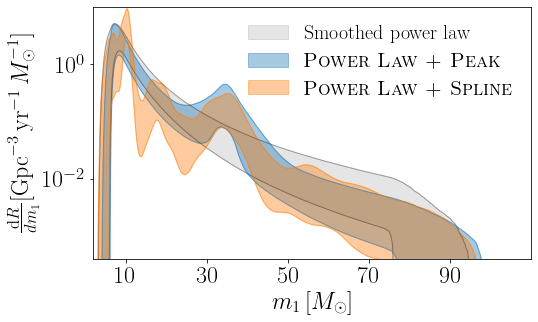

In [5]:
pp_fname = "/Users/amandafarah/proj/LIGO_data/GWTC-3-population-data/analyses/"\
"PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5"
mass_1 = np.linspace(2, 100, 1000)
with h5py.File(pp_fname,'r') as ff:
    pp_mass_data = ff["lines"]['mass_1'][()]

ps_fname = "/Users/amandafarah/proj/LIGO_data/GWTC-3-population-data/analyses/"\
"PowerLawSpline/o1o2o3/spline_20n_mass_m_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5"
with h5py.File(ps_fname,'r') as ff:
    ps_mass_data = ff["lines"]['mass_1'][()]

smoothed_fname = "o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5"
with h5py.File(smoothed_fname,'r') as ff:
    smoothed_mass_data = ff["lines"]['mass_1'][()]

plt.figure(figsize=(8,5))

# Truncated
plt.fill_between(mass_1,*np.percentile(smoothed_mass_data,[5,95],axis=0),
                 color="k",alpha=0.1,label='Smoothed power law',zorder=50)
plt.plot(mass_1,np.percentile(smoothed_mass_data,[5,95],axis=0).T,
                 color="k",alpha=0.3,lw=1,zorder=50)

# PLP
plt.fill_between(mass_1,*np.percentile(pp_mass_data,[5,95],axis=0),
                 color="#1f78b4",alpha=0.4,zorder=50,label='\\textsc{Power Law + Peak}')
plt.plot(mass_1,np.percentile(pp_mass_data,[5,95],axis=0).T,
                 color="#1f78b4",alpha=0.4,lw=1,zorder=50)

# Spline
plt.fill_between(mass_1,*np.percentile(ps_mass_data,[5,95],axis=0),
                 color="tab:orange",alpha=0.4,zorder=50,label='\\textsc{Power Law + Spline}')
plt.plot(mass_1,np.percentile(ps_mass_data,[5,95],axis=0).T,
                 color="tab:orange",alpha=0.4,lw=1,zorder=50)


plt.yscale('log')
plt.ylim(4e-4,10)
plt.xlim(2,110)
xticks = np.arange(start=1,stop=11,step=2,dtype=int)*10
plt.xticks(xticks,labels=[f'{int(l)}' for l in xticks])
plt.xlabel('$m_1 \\,[M_\\odot]$')
plt.ylabel(
    r"$\frac{\mathrm{d}R}{dm_{1}} [\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_{\odot}^{-1}]$"
)
plt.legend(edgecolor='white')
plt.tight_layout()
plt.savefig('figures/dR_dm1_multiple.pdf')
plt.show()

## Results 1: point-estimate observed distributions (histogram bin heights)

In [6]:
def load_injection_data(vt_file, ifar_threshold=1, snr_threshold=11):
    with h5py.File(vt_file, "r") as ff:
        data = ff["injections"]
        found = np.zeros_like(data["mass1_source"][()], dtype=bool)
        for key in data:
            if "ifar" in key.lower():
                found = found | (data[key][()] > ifar_threshold)
            if "name" in data.keys():
                gwtc1 = (data["name"][()] == b"o1") | (data["name"][()] == b"o2")
                found = found | (gwtc1 & (data["optimal_snr_net"][()] > snr_threshold))
        n_found = sum(found)
        found_data = dict(
            mass_1=np.asarray(data["mass1_source"][found]),
            mass_ratio=np.asarray(
                data["mass2_source"][found] / data["mass1_source"][found]
            ),
            redshift=np.asarray(data["redshift"][found]),
            total_generated=int(data.attrs["total_generated"][()]),
            analysis_time=data.attrs["analysis_time_s"][()] / 365.25 / 24 / 60 / 60,
        )
    return found_data

def change_pdraw(filename, alpha=None, mmin=None, mmax=None, size=None, plot=False, pop_model=None):
    """change the draw probability of the full injection set by resampling according to a powerlaw in primary mass.
    I think this might only work for the BBH-only or BNS-only injection sets and also
    could suffer from undersampling issues if your target and start distributions are very different.
    filename is the hdf5 files containing injections
    alpha is the powerlaw spectral index of the desired draw distribution
    """
    if alpha is None and pop_model is None:
        raise ValueError('Must specify either alpha or pop_model') 
    with h5py.File(filename, "r") as ff:
        try:
            data = ff["injections"]
            m1_sampling = np.array(data['mass1_source_sampling_pdf'])
        except KeyError:
            data = ff['events']
            m1_sampling = np.exp(np.array(data['logpdraw_mass1_source']))
        
        if alpha is None:
            variates = dict(mass_1=np.array(data['mass1_source']), 
                            mass_ratio=np.array(data['mass2_source'])/np.array(data['mass1_source'])
                           )
            weights = pop_model.prob(variates)/m1_sampling
        else:
            weights = np.power(data['mass1_source'][()],alpha)/m1_sampling

        if mmin is not None:
            weights[data['mass1_source'][()] < mmin] =0.
        if mmax is not None:
            weights[data['mass1_source'][()] > mmax] =0.
        weights /= np.sum(weights)

        if size is None:
            size = len(data['mass1_source'])
        indecies = np.random.choice(len(np.array(data['mass1_source'][()])), size=size, p=weights, replace=True)
        try:
            new_injs=dict(mass1_source=np.array(data['mass1_source'])[indecies],
                          ifar_pycbc_bbh=np.array(data['ifar_pycbc_bbh'])[indecies],
                          ifar_cwb=np.array(data['ifar_cwb'])[indecies] ,
                          ifar_gstlal=np.array(data['ifar_gstlal'])[indecies],
                          ifar_mbta=np.array(data['ifar_mbta'])[indecies],
                         )
        except ValueError:
            new_injs=dict(mass1_source=np.array(data['mass1_source'])[indecies],
                          snr_net=np.array(data['snr_net'])[indecies]
                         )
        
        if plot:
            # plot the process
            plt.figure(figsize=(15,10))
            heights, bins, _ = plt.hist(data['mass1_source'],
                                        bins=500, density=False, histtype='step', 
                                        label='original', color='blue')
            plt.plot(bins, (heights[0]/(bins[0]**(-2.35)))*bins**(-2.35),
                     label='nominal m1 sampling distribution',
                     color='blue')
            heights, bins, _ = plt.hist(np.array(data['mass1_source'])[indecies], 
                                        bins=bins, density=False, histtype='step', 
                                        label='resampled',color='orange')
            if alpha is None:
                alpha=-1*pop_model.parameters['alpha']
            plt.plot(bins, (heights[0]/(bins[0]**alpha))*bins**alpha, 
                     label='target m1 sampling distribution', color='orange')

            plt.legend()
            plt.xlabel('m1')
            plt.yscale('log')
            plt.xlim(2,20)
            plt.show()

            plt.scatter(data['mass1_source'],weights,label='weights', alpha=0.1)
            plt.xlabel('m1')
            plt.ylabel('weights')
            plt.show()
        
        return new_injs
    
def find_injections(data, ifar_threshold=1, snr_threshold=11, verbose=True):
    """Returns found injections for just primary mass as a np array given an injection set. 
    You change set the IFAR and SNR thresholds if you like."""

    for key in data:
        if "ifar" in key.lower():
            found = np.zeros_like(data["mass1_source"][()], dtype=bool)
            found = found | (data[key][()] > ifar_threshold)
        elif 'snr' in key.lower():
            found = data[key][()] > snr_threshold
    if verbose:
        n_found = sum(found)
        print(f"We found {n_found} injections out of {len(found)}.")
    found_data = np.asarray(data["mass1_source"][found])
    return found_data

def p_values(simulation_heights, data_heights):
    """for each bin, find the fraction of simulated 
    bin heights smaller than the data's bin height """
    num_less = np.sum(simulation_heights - data_heights < 0, axis=0)
    frac_less = num_less/len(simulation_heights)
    # do the same for bin heights larger than the data's
    frac_more = 1-frac_less
    return (frac_less, frac_more)

def make_histogram_plot(observations, injections, filename=None, **hist_kwargs):
    # just get the bin heights
    _, bins = np.histogram(observations, density=True, **hist_kwargs)
    heights = np.zeros((len(injections[0]),len(bins)-1))
    for i in range(len(injections[0])):
        heights[i], _ = np.histogram(np.vstack(injections[:,i]), density=True, bins=bins)
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(bins[:-1], np.median(heights,axis=0), drawstyle='steps-post', 
         color='k', label = 'Found Injections')
    plt.fill_between(bins[:-1], np.percentile(heights, 5, axis=0), np.percentile(heights, 95, axis=0),
                     step='post', alpha=0.3, color='k')
    plt.fill_between(bins[:-1], np.percentile(heights, 16.665, axis=0), np.percentile(heights, 83.335, axis=0),
                     step='post', alpha=0.3, color='k')
    plt.hist(observations, histtype='step', density=True, bins=bins, linewidth=3, color='tab:orange', zorder=50,
             label='Medians of O3 BBHs')
    plt.legend(edgecolor='white',framealpha=1)
    plt.ylabel('$p(m_1)\,[M_\\odot^{-1}]$')
    plt.xlabel('$m_1\,[M_\\odot]$')
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
def make_multi_histogram_plot(observations, injections1, injections2, return_pvals=True,
                              ax=None, lab1='$\\alpha=3.14$', lab2='$\\alpha=2.7$',
                              filename=None, **hist_kwargs):
        # just get the bin heights
    obs_heights, bins = np.histogram(observations, density=True, **hist_kwargs)
    heights1 = np.zeros((len(injections1[0]),len(bins)))
    heights2 = np.zeros((len(injections2[0]),len(bins)))
    for i in range(len(injections1[0])):
        heights1[i,:-1], _ = np.histogram(np.vstack(injections1[:,i]), density=True, bins=bins)
        heights2[i,:-1], _ = np.histogram(np.vstack(injections2[:,i]), density=True, bins=bins)    
    # for plotting purposes:
    heights1[:,-1] = heights1[:,-2]
    heights2[:,-1] = heights2[:,-2]
        
    if ax is None:
        ax = plt.figure(figsize=(10,7))
        ax.set_xlabel('$m_1\,[M_\\odot]$')
    ax.fill_between(bins, *np.percentile(heights1, [5,95], axis=0),
                     step='post', alpha=0.3, color='#DC267F',hatch='\\', label = 'Found Injections, '+lab1)
    ax.plot(bins, np.percentile(heights1, [5,95], axis=0).T,
                     drawstyle='steps-post', alpha=0.5, color='#DC267F')
    
    ax.fill_between(bins, *np.percentile(heights2, [5,95], axis=0),
                     step='post', alpha=0.3, color='#648FFF', hatch='/', label = 'Found Injections, '+lab2)
    ax.plot(bins, np.percentile(heights2, [5,95], axis=0).T,
                 drawstyle='steps-post', alpha=0.5, color='#648FFF')
    ax.hist(observations, histtype='step', density=True, bins=bins, linewidth=3, color='k', zorder=50, label='Medians of GWTC-3 BBHs')
    ax.legend(framealpha=1,edgecolor='white')
    ax.set_ylabel('$p(m_1)\,[M_\\odot^{-1}]$')
    if filename is not None:
        plt.savefig(filename)
    
    if return_pvals:
        print("bins are: ", bins)
        fl1, fm1 = p_values(heights1[:,:-1],obs_heights)
        print(f"for {lab1}, {fl1}% are less than observations")
        fl2, fm2 = p_values(heights2[:,:-1],obs_heights)
        print(f"for {lab2}, {fl2}% are less than observations")
        return bins, fl1, fl2
        
def plot_edf(data, x_ax, plot=True, ax=None, **plot_kwargs):
    counts, bin_edges = np.histogram(data, bins=x_ax, density=True)
    N_data=np.array([0])
    N_data = np.append(N_data, np.cumsum(counts)/np.sum(counts))
    if plot:
        if ax is None:
            ax = plt.figure(figsize=(7,10))
        ax.plot(x_ax, N_data, drawstyle='steps-post', **plot_kwargs)
    return N_data

### Load and reweight injections

In [9]:
# PS inferred parameters
a = 3.25 #np.median(posterior_gwtc_3["alpha"])
mmin = np.median(posterior_gwtc_3["mmin"])
mmax = np.median(posterior_gwtc_3["mmax"])

print(f'alpha: {a} \nmmin: {mmin} \nmmax: {mmax}')

alpha: 3.25 
mmin: 4.260091795401878 
mmax: 85.1309231867466


In [10]:
# If on CIT use: "/home/reed.essick/rates+pop/o3-sensitivity-estimates/LIGO-T2100113-v12/endo3_bbhpop-LIGO-T2100113-v12.hdf5"
filename = "../../../LIGO_data/injections/endo3_bbhpop-LIGO-T2100113-v12.hdf5"
resampled_injs = change_pdraw(filename, alpha=-a, mmin=mmin, mmax=mmax, plot=False)
found_injs = find_injections(resampled_injs)

We found 48685 injections out of 284672.


In [11]:
# print out injection population parameters
with h5py.File(filename,'r') as ff:
    for k in ff.attrs.keys():
        print(k, ff.attrs[k])

N_exp/R(z=0) 524.1837931943585
analysis_time_s 28749576
end_time_s 1269561618
max_mass1 100.0
max_mass2 100.0
max_redshift 1.9
max_spin1 0.998
max_spin2 0.998
max_z 1.9
min_mass1 2.0
min_mass2 2.0
n_accepted 284672
n_rejected 73672904
num_redshift_norm_grid_points 1001
pow_mass1 -2.35
pow_mass2 1.0
pow_z 1.0
ref_mass1 0.0
start_time_s 1238166018
surveyed_VT_Gpc_yr 242.25575747243002
total_generated 73957576


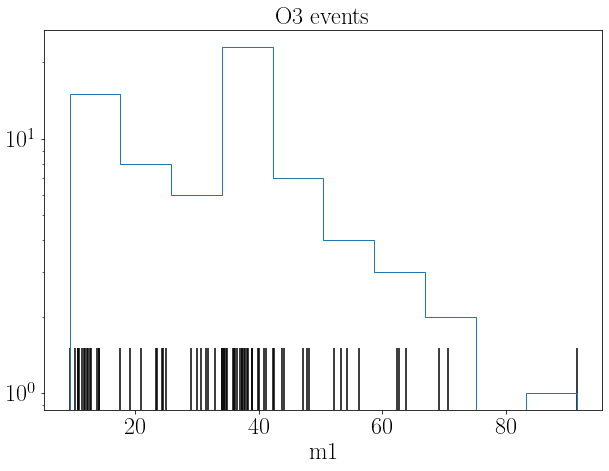

In [13]:
medians = all_bbhs.sel(parameter='mass_1').median().to_array()
plt.figure(figsize=(10,7))
plt.eventplot(medians, orientation='horizontal',colors='black')
plt.hist(medians, histtype='step')
plt.yscale('log')
plt.xlabel('m1')
plt.title('O3 events')
plt.show()

### CDFs and Histograms of injs and data
I think these are basically PPCs that only take into account random clustering, not event-level uncertainty.

We found 49879 injections out of 284672.
We found 48844 injections out of 284672.
bins are:  [ 9.43132817 13.53701677 17.64270537 21.74839398 25.85408258 29.95977118
 34.06545978 38.17114838 42.27683699 46.38252559 50.48821419 54.59390279
 58.69959139 62.80528    66.9109686  71.0166572  75.1223458  79.2280344
 83.33372301 87.43941161 91.54510021]
for $\alpha=3.25$, [0.4306 0.0281 0.0965 0.4027 0.0391 0.6931 1.     0.932  0.7279 0.6177
 0.6844 0.26   0.6814 0.3399 0.7669 0.     0.     0.     0.     0.6765]% are less than observations
for $\alpha=2.7$, [0.9087 0.0965 0.1828 0.5125 0.018  0.6907 1.     0.9069 0.6605 0.4891
 0.5025 0.091  0.3325 0.1461 0.5235 0.     0.     0.     0.     0.4003]% are less than observations


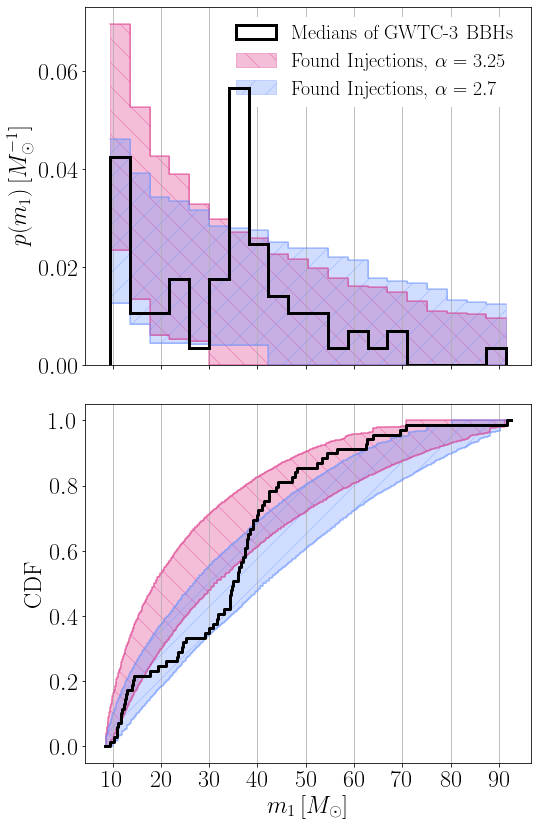

In [14]:
# construct predicted events
num_realizations=int(1e4)
resampled_injs = change_pdraw(filename, alpha=-2.7, mmin=mmin, mmax=92, plot=False)
found_injs_27 = find_injections(resampled_injs)
resampled_injs = change_pdraw(filename, alpha=-3.25, mmin=mmin, mmax=92, plot=False)
found_injs_314 = find_injections(resampled_injs)
drawn_events_27 = np.random.choice(found_injs_27,size=(len(all_bbhs.data_vars),num_realizations))
drawn_events_314 = np.random.choice(found_injs_314,size=(len(all_bbhs.data_vars),num_realizations))
# construct predicted CDFs
m_space = np.linspace(np.min(medians)-1,np.max(medians)+1,num=500)
inj_cdfs_27 = np.zeros((num_realizations,len(m_space)))
inj_cdfs_314 = np.zeros((num_realizations,len(m_space)))
for i in range(num_realizations):
    inj_cdfs_27[i] = plot_edf(drawn_events_27[:,i],x_ax=m_space,plot=False)
    inj_cdfs_314[i] = plot_edf(drawn_events_314[:,i],x_ax=m_space,plot=False)

    
# plot

fig, ax = plt.subplots(figsize=(8,12),nrows=2,ncols=1,sharex=True)

bins, rhi314, rhi27 = make_multi_histogram_plot(medians,drawn_events_314,drawn_events_27,
                                                bins=20, ax=ax[0], return_pvals=True,
                                                lab1='$\\alpha=3.25$',lab2='$\\alpha=2.7$'
                                               )
ax[0].grid(which='both', axis='x',zorder=0)

plot_edf(medians, x_ax=m_space,ax=ax[1], label='Medians of GWTC-3 BBHs',color='k',zorder=50,linewidth=3)##FFB000

plt.fill_between(m_space, np.percentile(inj_cdfs_314, 5, axis=0), np.percentile(inj_cdfs_314, 95, axis=0),
                 step='post', alpha=0.3, color='#DC267F',
                 hatch='\\', label='Found injections, $\\alpha=3.25$')
# hatching bug workaround
# plt.fill_between(m_space, np.percentile(inj_cdfs_314, 5, axis=0), np.percentile(inj_cdfs_314, 95, axis=0),
#                  step='post', alpha=0.3, color='None', edgecolor='#DC267F', linewidth=2,hatch='\\')
# add edges
plt.plot(m_space, np.percentile(inj_cdfs_314, 5, axis=0),
                 drawstyle='steps-post', alpha=0.5, color='#DC267F')
plt.plot(m_space, np.percentile(inj_cdfs_314, 95, axis=0),
                 drawstyle='steps-post', alpha=0.5, color='#DC267F')

plt.fill_between(m_space, np.percentile(inj_cdfs_27, 5, axis=0), np.percentile(inj_cdfs_27, 95, axis=0),
                 step='post', alpha=0.3, color='#648FFF', hatch='/', label='Found injections, $\\alpha=2.7$')
plt.plot(m_space, np.percentile(inj_cdfs_27, 5, axis=0),
                 drawstyle='steps-post', alpha=0.5, color='#648FFF')
plt.plot(m_space, np.percentile(inj_cdfs_27, 95, axis=0),
                 drawstyle='steps-post', alpha=0.5, color='#648FFF')


plt.grid(which='both', axis='x',zorder=0)
# plt.legend(fontsize=20)
# plt.annotate(f'Power Law with $\\alpha=${a}',xy=(50,0.5),fontsize=20)
plt.xlabel('$m_1\,[M_\\odot]$')
plt.xticks(range(10,100,10))
plt.ylabel('CDF')
plt.tight_layout()
plt.savefig('figures/point_estimate_observed_plaw_20_bins_and_CDF.pdf')
# plt.savefig('figures/hatching_test.pdf')
plt.show()

### $r_h^i$ calculations

In [ ]:
def most_sig_3(arr):
    sort = np.delete(arr,arr==0)
    sort = np.sort(np.append(sort, 1-sort))
    three_largest_deviation_indecies = [] #np.zeros(3,dtype=int)
    for i in range(3):
        idx = np.argwhere(arr==sort[-1])
        if len(idx)==0:
            idx= np.argwhere(arr==sort[0])
        for j in range(len(idx)):
            three_largest_deviation_indecies.append(idx[j])
            sort=np.delete(sort,[0,-1])
    return np.array(three_largest_deviation_indecies[:3],dtype=int).T[0]

In [ ]:
print("For alpha=3.25")
idxs = most_sig_3(rhi314)    
for idx in idxs:
    print(f"The bin centered on: {np.mean([bins[idx],bins[idx+1]]):.2f} has r_h^i = {rhi314[idx]}")
    
print("For alpha=2.7")
idxs = most_sig_3(rhi27)
for idx in idxs:
    print(f"The bin centered on: {np.mean([bins[idx],bins[idx+1]]):.2f} has r_h^i = {rhi27[idx]}")


## Results 2: PS runs

### Plots

#### Perturbation function

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


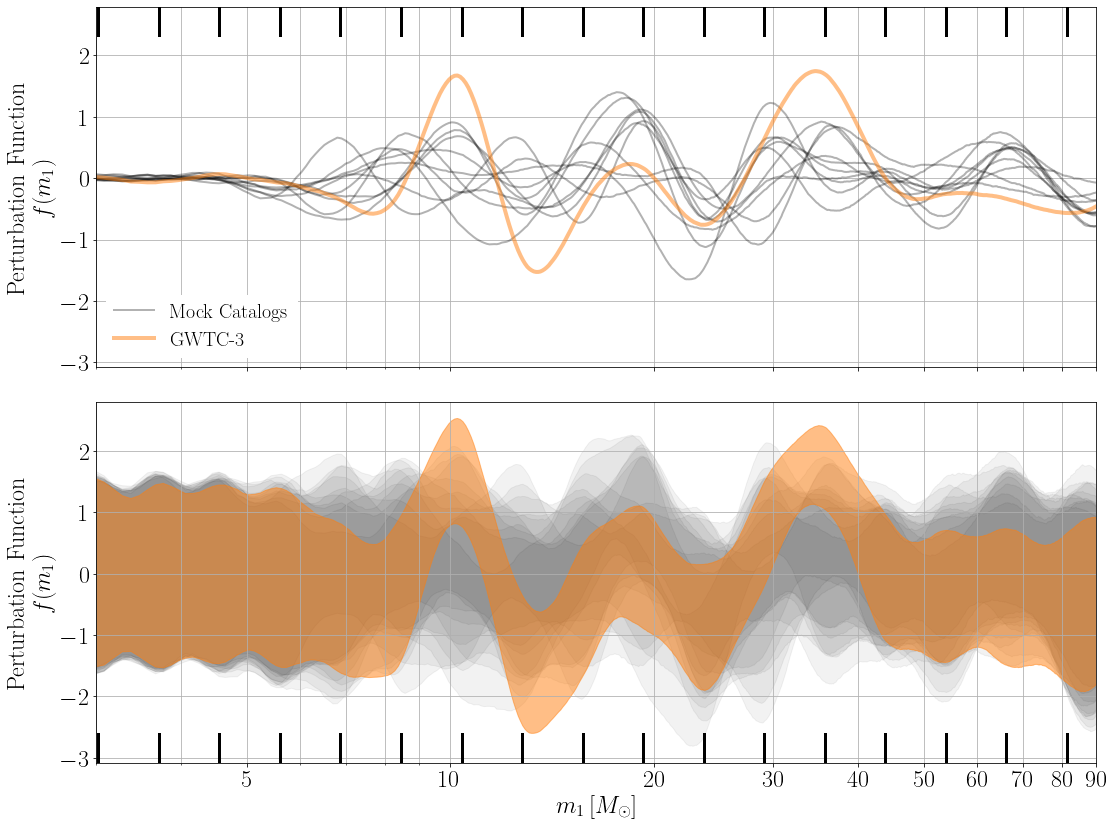

In [16]:
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(16,12), sharex=True, sharey=True)
for i in range(2):
    ax[i].set_ylabel('Perturbation Function\n$f(m_1)$')
    ax[i].grid(which = 'both',zorder=0)
for run in trange(10):
    pert = perturbation_functions[f'run_{run}']
    low, med, high = np.percentile(pert, (5,50,95), axis=0)
    lab=None
    if run==9:
        lab='Mock Catalogs'
    ax[0].plot(ms,med,alpha=0.3,linewidth=2,color='k',label=lab)
    ax[1].fill_between(ms, low, high, alpha=0.05, color='k')
ax[0].plot(ms,np.percentile(gwtc_3_pert,50,axis=0), alpha=0.5, linewidth=4,color='tab:orange', label='GWTC-3')
ax[1].fill_between(ms, *np.percentile(gwtc_3_pert,(5,95),axis=0), alpha=0.5, color='tab:orange')
# knot locations
for m in m_spls_gwtc3:
    ax[0].axvline(m, alpha=1, color='k', ymin=.92,ymax=1,lw=3)
    ax[1].axvline(m, alpha=1, color='k', ymin=0,ymax=0.08,lw=3)
ax[0].legend(framealpha=1,edgecolor='white')
plt.xscale('log')
xticks = np.append([5],np.arange(start=1,stop=10,dtype=int)*10)
plt.xticks(xticks,labels=[f'{int(l)}' for l in xticks])
plt.xlim(3,90)
plt.xlabel('$m_1 \\,[M_\\odot]$')
plt.tight_layout()
plt.savefig('figures/perturbation_function_10_catalogs_alt.pdf')
plt.show()

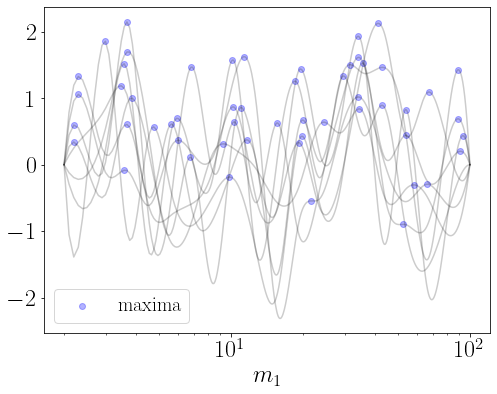

In [17]:
# check the extremum finder:
subset = gwtc_3_pert[8:16]
idxs = argrelmax(subset, axis=1)
extrema = subset[idxs]
plt.figure(figsize=(8,6))
for l in range(8):
    plt.plot(ms,subset[l],c='k',alpha=0.2)
plt.scatter(ms[idxs[1]],subset[idxs],c='b',alpha=0.3, label='maxima')
plt.xscale('log')
plt.xlabel('$m_1$')
plt.legend()
plt.show()

Seems like the extremum-finding algorithm works.

#### Largest extrema distributions

In [19]:
# choose a single place to get the distribution of perturbation function heights 
def loc_max_extrema(pert,num_max=1):
    # find all the extrema
    local_maxima = pert[argrelmax(pert)] 
    # have to do both rather than finding the maxima of the absolute values becasue of behavior near zero.
    local_minima = pert[argrelmin(pert)]
    local_extrema = np.append(local_maxima,local_minima) 
    # take the N largest of them
    abs_extrema = np.sort(np.abs(local_extrema))[-num_max:]
    # return the locations of them
    locs = np.array([np.argwhere(np.abs(pert) == ae)[0] for ae in abs_extrema])
    return pert[locs], locs.T

def percentile_of_score(array, score):
    score = score[..., None]
    left = np.count_nonzero(array < score, 0)
    right = np.count_nonzero(array <= score, 0)
    plus1 = left < right
    return (left + right + plus1) * (50.0 / len(array))

def n_max_extrema(pert, num_maximum=None):
    if num_maximum is None: # this is currenly not supported
        abs_extrema = []
    else:
        abs_extrema = np.zeros((len(pert),num_maximum))
    for i, p in enumerate(pert): 
        # find all the extrema
        local_maxima = p[argrelmax(p)] 
        # have to do both rather than finding the maxima of the absolute values becasue of behavior near zero.
        local_minima = p[argrelmin(p)]
        local_extrema = np.append(local_maxima,local_minima)
        if num_maximum is None:
            abs_extrema.append(np.abs(local_extrema))
        else: 
            # take the 3 largest of them
            abs_extrema[i] = np.sort(np.abs(local_extrema))[-num_maximum:]
    return abs_extrema

num_PE_samples = np.inf
for r in perturbation_functions:
    if num_PE_samples> len(perturbation_functions[r]):
        num_PE_samples = len(perturbation_functions[r])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [28:32<00:00,  5.69s/it]


KS:  0.15734925663072152
percentile:  68.25857519788919 [ 60.84432718 -31.13456464]
KS:  0.0945795300272624
percentile:  78.39050131926122 [ 69.05013193 -21.55672823]
KS:  0.03366408759285218
percentile:  93.77308707124011 [79.84168865 -6.22691293]


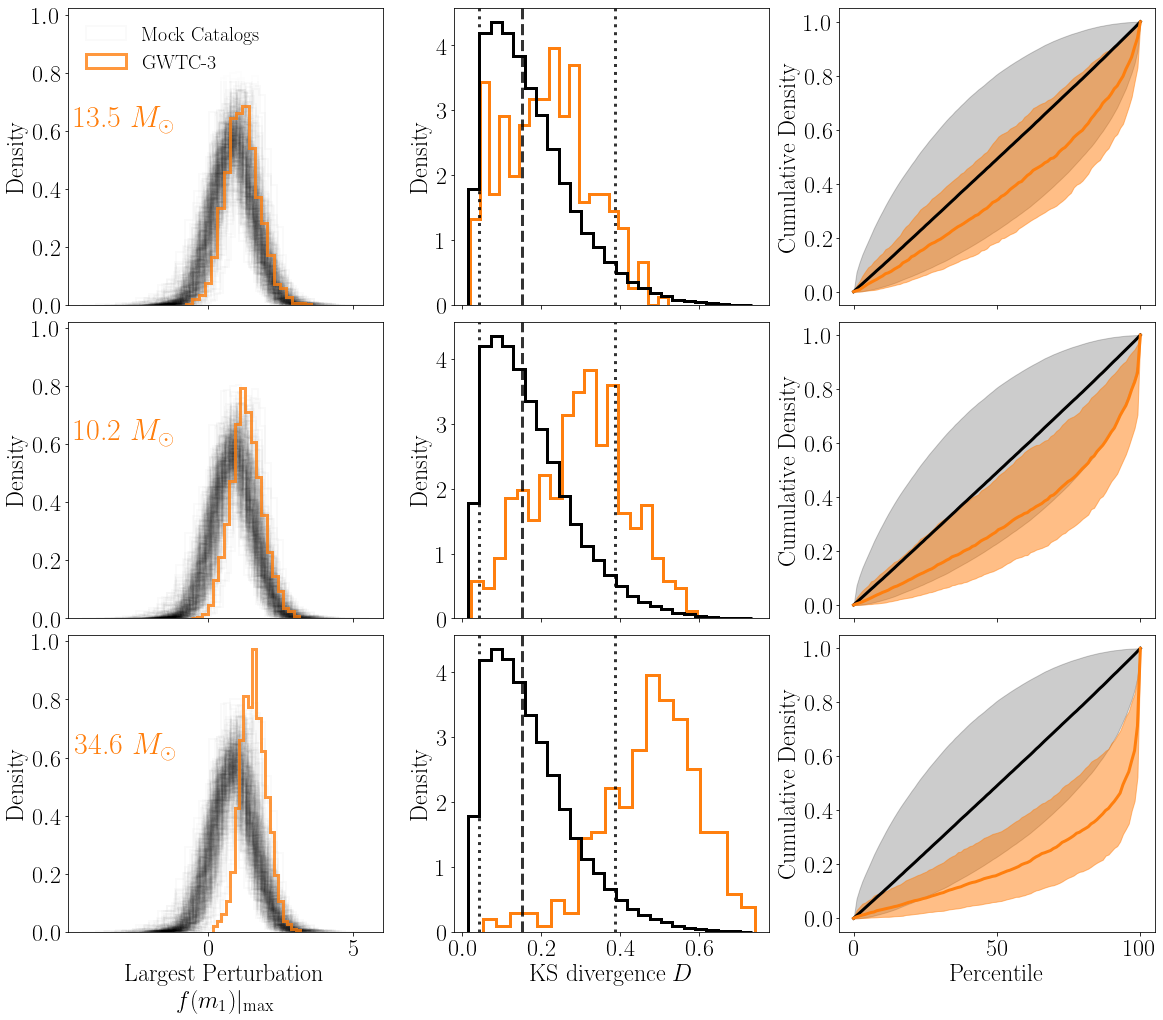

In [20]:
# offset statistic
fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(16,14), sharex='col',sharey='col')
axs = axs.reshape((3,3))

## FIRST COLUMN
# get the distributions for each mock catalog
vals, locs = loc_max_extrema(np.percentile(gwtc_3_pert,50,axis=0),num_max=3)
abs_extrema = np.zeros((num_mock_catalogs,num_PE_samples))
exclude_zero_fracs = np.zeros(num_mock_catalogs)
for run in tqdm(range(num_mock_catalogs)):
    pert = perturbation_functions[f'run_{run}']
    # use the median of the perturbation function to identify the largest perturbation
    vals_mock, locs_mock = loc_max_extrema(np.percentile(pert,50,axis=0),num_max=1)
    extrema = pert[:num_PE_samples,locs_mock]
    # if the majority of the distribution is negative, flip the whole thing about x=0
    if np.sum(extrema<0) > len(extrema)/2:
        abs_extrema[run] = -1 * extrema.T
    else:
        abs_extrema[run] = extrema.T
    exclude_zero_fracs[run] = np.sum(abs_extrema[run] < 0)/num_PE_samples
    for i in range(3):
        if run ==1:
            axs[i,0].hist(abs_extrema[run], bins=20, histtype='step', lw=2, alpha=0.02, color='k', density=True,
                          label='Mock Catalogs')
        else:
            axs[i,0].hist(abs_extrema[run], bins=20, histtype='step', lw=2, alpha=0.02, color='k', density=True)
## SECOND AND THIRD COLUMNS
Ds = np.empty((num_mock_catalogs,num_mock_catalogs))
Ds[:]=np.nan
# Ds = np.zeros(num_mock_catalogs)
ps=np.copy(Ds)
D_gwtc3 = np.zeros(num_mock_catalogs)
perc_x = np.linspace(0,100,num=100)
percentiles = np.zeros((num_mock_catalogs,num_PE_samples))
cdfs = np.zeros((num_mock_catalogs,len(perc_x)))
null_percentiles=np.empty((num_mock_catalogs,num_mock_catalogs,num_PE_samples))
null_percentiles[:]=np.nan
null_cdfs = np.zeros((num_mock_catalogs,num_mock_catalogs,len(perc_x)))
null_cdfs[:]=np.nan
for run in tqdm(range(num_mock_catalogs)):
#     Ds[run], ps[run] = stats.ks_2samp(mean_dist,abs_extrema[run])
    # null dists
    for r in range(num_mock_catalogs):
        if r>run:
            Ds[run,r], ps[run,r] = stats.ks_2samp(abs_extrema[r],abs_extrema[run],alternative='two-sided')
            null_percentiles[run,r] = percentile_of_score(abs_extrema[run],abs_extrema[r])
#             for i in range(3):
#                 axs[i,2].hist(null_percentiles[run,r], bins=100, histtype='step', lw=1, alpha=0.1, color='k', density=True,cumulative=True)
            null_cdfs[run,r] = plot_edf(null_percentiles[run,r],x_ax=perc_x,plot=False)

# COMBINED AND GWTC-3 CURVES
mean_dist = abs_extrema.flatten()
vals, locs = loc_max_extrema(np.percentile(gwtc_3_pert,50,axis=0),num_max=3)
null_cdfs = null_cdfs.transpose(2,0,1).reshape(len(perc_x),-1)
for i in range(3):
#     axs[i,0].hist(mean_dist,bins=20, histtype='step', lw=3, color='k',density=True, label='Combined\nMock Catalogs')
    if i ==0:
        gwtc_3_maxima = -1*gwtc_3_pert[:num_PE_samples,locs[0][i]]
    else:
        gwtc_3_maxima = gwtc_3_pert[:num_PE_samples,locs[0][i]]
    axs[i,0].hist(gwtc_3_maxima,bins=20, histtype='step', lw=3, alpha=0.8, color='tab:orange', density=True, label='GWTC-3')
    axs[i,0].annotate(f"{round(ms[locs[0][i]],1)} $M_\odot$",(0.02,0.6),
                      xycoords='axes fraction', color='tab:orange',fontsize=30)
    
    num_larger=0
    for run in range(num_mock_catalogs):
        # 2nd column
        D_gwtc3[run], p_gwtc_3 = stats.ks_2samp(abs_extrema[run],gwtc_3_maxima,alternative='two-sided')
        num_larger += np.sum(Ds[run] > D_gwtc3[run])
        # 3rd column
        percentiles[run] = percentile_of_score(abs_extrema[run],gwtc_3_maxima)
        cdfs[run] = plot_edf(percentiles[run],x_ax=perc_x,plot=False)
#         axs[i,2].hist(percentiles[run], bins=100, histtype='step', lw=1, alpha=0.2, color='tab:orange',
#                       density=True, cumulative=True)
    print("KS: ",num_larger/num_mock_catalogs**2)
    print("percentile: ",np.percentile(percentiles,50), 
          np.percentile(percentiles,50) - np.percentile(percentiles,[5,95]))
    # 2nd column
    # D_gwtc3, p_gwtc_3 = stats.ks_2samp(mean_dist,gwtc_3_maxima)
    # axs[1].axvline(D_gwtc3,lw=3, alpha=0.8, color='tab:orange')
    axs[i,1].hist(D_gwtc3, bins=20, histtype='step', lw=3, color='tab:orange', density=True)
    axs[i,1].hist(Ds.flatten(), bins=25, histtype='step', lw=3, color='k', density=True)
    axs[i,1].axvline(np.nanmedian(Ds), lw=3, alpha=0.8, color='k',linestyle='--')
    axs[i,1].axvline(np.nanpercentile(Ds,95), lw=3, alpha=0.8, color='k',linestyle=':')
    axs[i,1].axvline(np.nanpercentile(Ds,5), lw=3, alpha=0.8, color='k',linestyle=':')
    # 3rd column
    axs[i,2].fill_between(perc_x, *np.nanpercentile(null_cdfs,(5,95),axis=1), alpha=0.2, color='k')
    axs[i,2].plot(perc_x, np.nanpercentile(null_cdfs,50,axis=1), lw=3, color='k')    
#     axs[i,2].hist(null_percentiles.flatten(), bins=100, histtype='step', lw=3, color='k',
#                   density=True, cumulative=True)
    axs[i,2].fill_between(perc_x, *np.nanpercentile(cdfs,(5,95),axis=0), alpha=0.5, color='tab:orange')    
    axs[i,2].plot(perc_x, np.nanpercentile(cdfs,50,axis=0), lw=3, color='tab:orange')    
#     axs[i,2].hist(percentiles.flatten(), bins=100, histtype='step', lw=3, color='tab:orange',
#                   density=True, cumulative=True)
    
    # axs[i,2].set_yscale('log')
    axs[i,0].set_ylabel('Density')
    axs[i,1].set_ylabel('Density')
    axs[i,2].set_ylabel('Cumulative Density')

axs[0,0].legend(loc='upper left',edgecolor='white')  
axs[2,0].set_xlabel('Largest Perturbation \n $f(m_1)|_{\mathrm{max}}$')
axs[2,2].set_xlabel('Percentile')
axs[2,1].set_xlabel('KS divergence $D$')
fig.tight_layout(w_pad=.4,h_pad=0, pad=0)
plt.savefig('figures/three_largest_perturbations.pdf')
plt.show()

#### Zero-exclusion histogram

In [23]:
from scipy.stats import norm

def binomial_credible_interval(phat, n, z):
    offset = np.sqrt(phat * (1 - phat) / n + z ** 2 / (4 * n ** 2))
    my_1 = np.ones((len(phat), 2))
    return (
        1.0
        / (1 + z ** 2 / n)
        * (
            np.outer(phat, np.array([1, 1]))
            + my_1 * z ** 2 / (2 * n)
            + np.outer(z * offset, np.array([-1, 1]))
        )
    )

def binomial_credible_interval_default(phat, n, nParams=1,pval=0.9):
    z_fiducial = norm.ppf((np.power(1 - (1.0 - pval) / 2, 1.0 / nParams)))
    return binomial_credible_interval(phat, n, z_fiducial)

def compare_zero_fracs(gwtc3_frac,mock_fracs):
    for f in gwtc3_frac:
        if f>.5:
            print(f, (np.sum(mock_fracs<1-f)+np.sum(mock_fracs>f))/num_mock_catalogs*100)
        else:
            print(f, (np.sum(mock_fracs<f)+np.sum(mock_fracs>1-f))/num_mock_catalogs*100)

binomial_credible_interval_default(
    np.array([np.count_nonzero(gwtc_3_pert[:,locs[0][1]] <= 0) / len(gwtc_3_pert[:,locs[0][1]])]), len(gwtc_3_pert[:,locs[0][1]])
)[-1]

array([0.00055588, 0.00115489])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:32<00:00,  9.32it/s]


0.005152452746819636 1.3289036544850499
0.001154892241234064 0.0
0.00010838342219699339 0.0


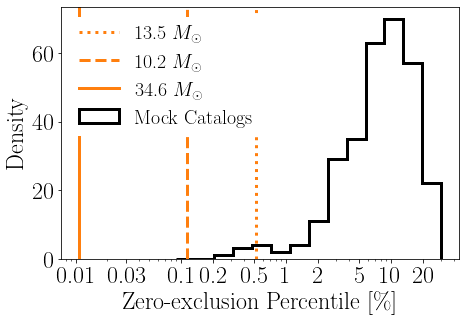

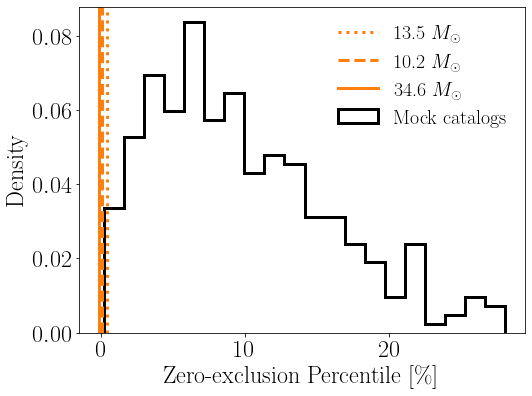

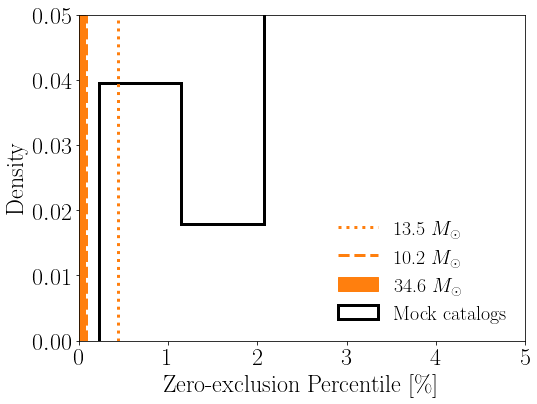

In [24]:
# a few different versions
exclude_zero_fracs = np.zeros(num_mock_catalogs)
for run in tqdm(range(num_mock_catalogs)):
    pert = perturbation_functions[f'run_{run}']
    vals_mock, locs_mock = loc_max_extrema(np.percentile(pert,50,axis=0),num_max=1)
    ## mock catalogs: what percentage of posterior draws exclude zero at those points
#     f = np.sum(pert[:,locs_mock] < 0,axis=0)/len(pert)
    l, f = binomial_credible_interval_default(
    np.array([np.count_nonzero(pert[:,locs_mock] <= 0) / len(pert[:,locs_mock])]), len(pert[:,locs_mock])
)[-1]
    if f >.5:
        f = 1-l
    exclude_zero_fracs[run] = f
    
fig = plt.figure(figsize=(7,5))
styles = ['dotted','dashed','solid']
for i in range(3):
    gwtc_3_maxima = gwtc_3_pert[:,locs[0][i]]
#     exclude_zero_fracs_gwtc_3 = np.sum(gwtc_3_maxima <= 0,axis=0)/len(gwtc_3_maxima)
    l, exclude_zero_fracs_gwtc_3 = binomial_credible_interval_default(
    np.array([np.count_nonzero(gwtc_3_maxima <= 0) / len(gwtc_3_maxima)]), len(gwtc_3_maxima)
)[-1]
    if exclude_zero_fracs_gwtc_3 > 0.5:
        exclude_zero_fracs_gwtc_3 = 1-l
    compare_zero_fracs([exclude_zero_fracs_gwtc_3],exclude_zero_fracs)
    plt.axvline(exclude_zero_fracs_gwtc_3*100, lw=3, color='tab:orange',
                ls=styles[i], label=f"{round(ms[locs[0][i]],1)} $M_\odot$")
# plt.axvspan(0,1/len(gwtc_3_maxima), color='tab:orange',label=f"{round(ms[locs[0][2]],1)} $M_\odot$")
bins = np.logspace(np.log10(.09),np.log10(30),num=15)
plt.hist(exclude_zero_fracs*100, bins=bins, histtype='step', lw=3, color='k', label='Mock Catalogs')
plt.xscale('log')
xticks = [0.01, 0.03, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
plt.xticks(xticks,labels=[f'{l}' for l in xticks])
plt.xlabel('Zero-exclusion Percentile [\%]')
plt.ylabel('Density')
plt.legend(loc='upper left',framealpha=1,edgecolor='white')
plt.tight_layout()
plt.savefig('figures/zero_exclusion_perc_log.pdf')
plt.show()

fig = plt.figure(figsize=(8,6))
styles = ['dotted','dashed','solid']
for i in range(2):
    if i ==0:
        gwtc_3_maxima = -1*gwtc_3_pert[:,locs[0][i]]
    else:
        gwtc_3_maxima = gwtc_3_pert[:,locs[0][i]]
    exclude_zero_fracs_gwtc_3 = np.sum(gwtc_3_maxima < 0,axis=0)/len(gwtc_3_maxima)
    plt.axvline(exclude_zero_fracs_gwtc_3*100, lw=3, color='tab:orange',
                ls=styles[i], label=f"{round(ms[locs[0][i]],1)} $M_\odot$")
plt.axvline(exclude_zero_fracs_gwtc_3*100-.2, color='tab:orange',lw=3,label=f"{round(ms[locs[0][2]],1)} $M_\odot$")
plt.hist(exclude_zero_fracs*100, bins=20,histtype='step', lw=3, color='k', density=True,label='Mock catalogs')
# plt.xlim(0,25)
plt.ylabel('Density')
plt.legend(edgecolor='white')
plt.xlabel('Zero-exclusion Percentile [\%]')
plt.savefig('figures/zero_exclusion_perc.pdf')
plt.show()

fig = plt.figure(figsize=(8,6))
styles = ['dotted','dashed','solid']
for i in range(2):
    if i ==0:
        gwtc_3_maxima = -1*gwtc_3_pert[:,locs[0][i]]
    else:
        gwtc_3_maxima = gwtc_3_pert[:,locs[0][i]]
    exclude_zero_fracs_gwtc_3 = np.sum(gwtc_3_maxima < 0,axis=0)/len(gwtc_3_maxima)
    plt.axvline(exclude_zero_fracs_gwtc_3*100, lw=3, color='tab:orange',
                ls=styles[i], label=f"{round(ms[locs[0][i]],1)} $M_\odot$")
plt.axvspan(0,exclude_zero_fracs_gwtc_3*100-.01, color='tab:orange',label=f"{round(ms[locs[0][2]],1)} $M_\odot$")
plt.hist(exclude_zero_fracs*100, bins=30,histtype='step', lw=3, color='k', density=True,label='Mock catalogs')
plt.xlim(0,5)
plt.ylim(0,0.05)
plt.xlabel('Zero-exclusion Percentile [\%]')
plt.ylabel('Density')
plt.legend(loc='lower right',edgecolor='white')
plt.show()

### Things we didn't end up using

100%|██████████| 13/13 [01:08<00:00,  5.26s/it]


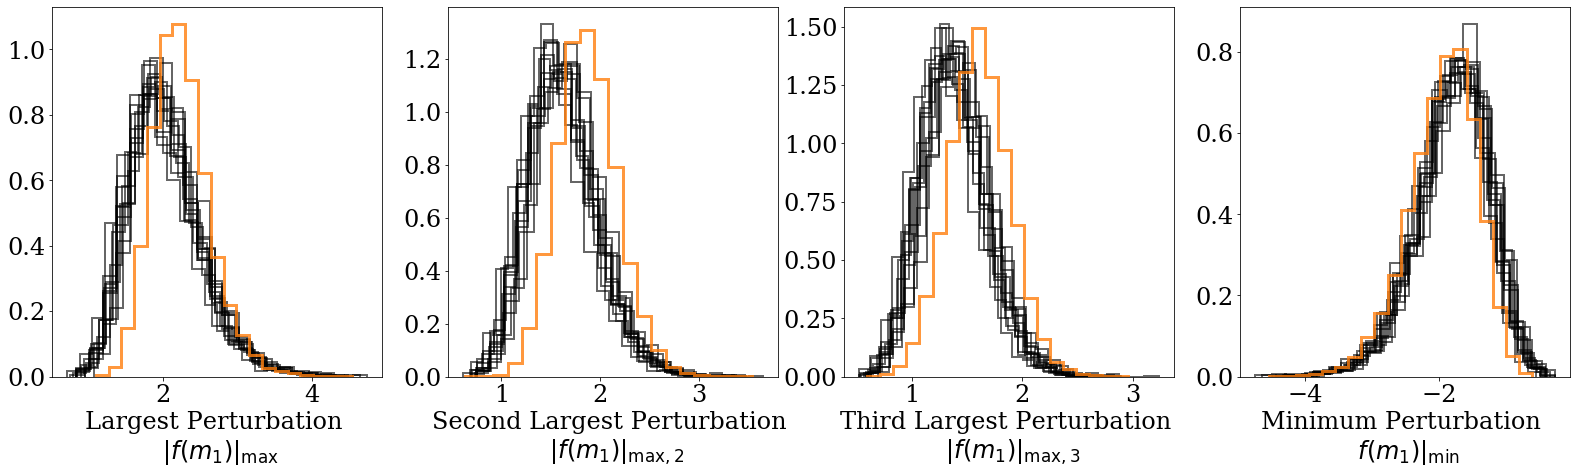

In [31]:
# 3 maximum perturbation function amplitudes
fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(16*1.7,4*1.7))
for run in tqdm(range(num_mock_catalogs)):
    pert = perturbation_functions[f'run_{run}']
    abs_extrema = n_max_extrema(pert, num_maximum=3)
    three_largest = np.flip(abs_extrema, axis=1)
    for i,ax in enumerate(axs):
        if i==3:
            ax.hist(np.min(pert,axis=1), bins=20, histtype='step', lw=2, alpha=0.6, color='k', density=True)
        else:
            ax.hist(three_largest[:,i], bins=20, histtype='step', lw=2, alpha=0.6, color='k', density=True)
        
abs_perts = n_max_extrema(gwtc_3_pert,num_maximum=3)
three_largest = np.flip(abs_perts, axis=1)
for i,ax in enumerate(axs):
    if i==3:
        ax.hist(np.min(gwtc_3_pert,axis=1), bins=20, histtype='step', lw=3, alpha=0.8, color='tab:orange', density=True)
    else:
        ax.hist(three_largest[:,i], bins=20, histtype='step', lw=3, alpha=0.8, color='tab:orange', density=True)
axs[0].set_xlabel('Largest Perturbation \n $|f(m_1)|_{\mathrm{max}}$')
axs[1].set_xlabel('Second Largest Perturbation \n $|f(m_1)|_{\mathrm{max,2}}$')
axs[2].set_xlabel('Third Largest Perturbation \n $|f(m_1)|_{\mathrm{max,3}}$')
axs[3].set_xlabel('Minimum Perturbation \n $f(m_1)|_{\mathrm{min}}$')
plt.savefig('figures/three_largest_perturbations.pdf')
fig.show()

100%|██████████| 13/13 [01:09<00:00,  5.35s/it]


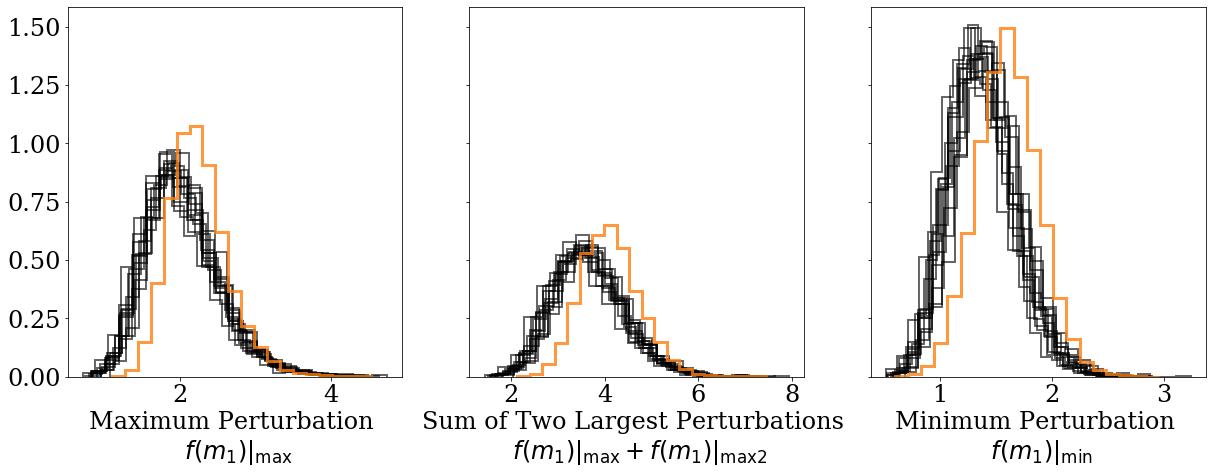

In [32]:
# how likely is it that we have 2 large perturbations?
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(12*1.7,4*1.7), sharey=True)
for run in tqdm(range(num_mock_catalogs)):
    pert = perturbation_functions[f'run_{run}']
    abs_extrema = n_max_extrema(pert, num_maximum=3)
    stats = [abs_extrema[:,-1],np.sum(abs_extrema[:,-2:],axis=1), abs_extrema[:,0]] # largest, sum of 2 largest, and smallest
    for i,ax in enumerate(axs):
        ax.hist(stats[i], bins=20, histtype='step', lw=2, alpha=0.6, color='k', density=True)        

abs_perts = n_max_extrema(gwtc_3_pert,num_maximum=3)
stats = [abs_perts[:,-1],np.sum(abs_perts[:,-2:],axis=1), abs_perts[:,0]] # largest, sum of 2 largest, and smallest
for i,ax in enumerate(axs):
        ax.hist(stats[i], bins=20, histtype='step', lw=3, alpha=0.8, color='tab:orange', density=True)
        
axs[0].set_xlabel('Maximum Perturbation \n $f(m_1)|_{\mathrm{max}}$')
axs[1].set_xlabel('Sum of Two Largest Perturbations \n $f(m_1)|_{\mathrm{max}} + f(m_1)|_{\mathrm{max}2}$')
axs[2].set_xlabel('Minimum Perturbation \n $f(m_1)|_{\mathrm{min}}$')
plt.savefig('figures/sum_largest_perturbations.pdf')
fig.show()

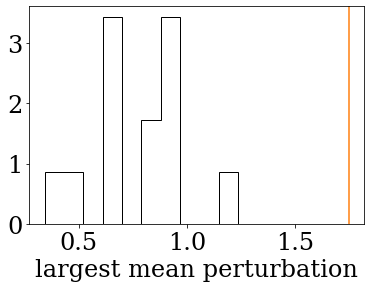

In [34]:
# largest mean of the perturbation function
lmp_gwtc3 = np.mean(gwtc_3_pert,axis=0).max()
lmp_mock = [perturbation_functions[k].mean(axis=0).max() for k in perturbation_functions.keys()]
plt.hist(lmp_mock, density=True, histtype='step', color='k')
plt.axvline(lmp_gwtc3, c='tab:orange')
plt.xlabel('largest mean perturbation')
plt.show()

In [96]:
(100-np.nanmean(percentiles))/2

30.455443808953216

In [108]:
np.percentile(Ds,90)

0.30698952718627676

_Suggestion_: For the significance of the GWTC-3 perturbation, integrate KS stat distribution until you get to the orange line, 1- that value is the pvalue you want. In other words, we don't want sigma since that assumes some symmetric distribution, we want a percentile.

100%|██████████| 295/295 [01:21<00:00,  3.64it/s]


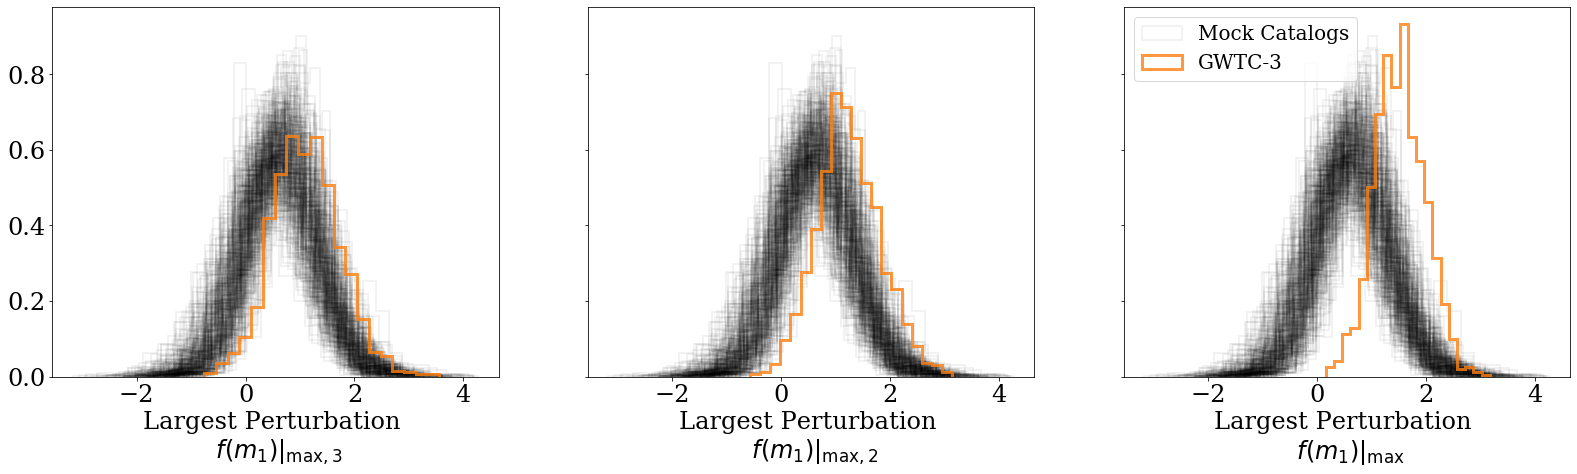

In [94]:
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(16*1.7,4*1.7), sharey=True, sharex=True)

# get the distributions for each mock catalog
abs_extrema = np.zeros((num_mock_catalogs,3,num_PE_samples))

for run in tqdm(range(num_mock_catalogs)):
    pert = perturbation_functions[f'run_{run}']
    # use the median of the perturbation function to identify the largest perturbation
    vals_mock, locs_mock = loc_max_extrema(np.percentile(pert,50,axis=0),num_max=3)
    extrema = pert[:num_PE_samples,locs_mock[0]].T
    
    # if the majority of the distribution is negative, flip the whole thing about x=0
    for i in range(3):
        if np.sum(extrema[i]<0) > num_PE_samples/2:
            abs_extrema[run,i] = -1 * extrema[i]
        else:
            abs_extrema[run,i] = extrema[i]
    
        if run ==1 and i==2:
            axs[i].hist(abs_extrema[run,0], bins=20, histtype='step', lw=2, alpha=0.05, color='k', density=True, label='Mock Catalogs')
        else:
            axs[i].hist(abs_extrema[run,0], bins=20, histtype='step', lw=2, alpha=0.05, color='k', density=True)

# gwtc_3_maxima = gwtc_3_pert[:,np.isclose(ms,location_vals_gwtc_3[0],atol=0.1)].mean(axis=1)
# gwtc_3_maxima = three_largest[:,0]
vals, locs = loc_max_extrema(np.percentile(gwtc_3_pert,50,axis=0),num_max=3)
gwtc_3_maxima = gwtc_3_pert[:num_PE_samples,locs[0]]
for i in range(3):    
    # get the mean
    mean_dist = abs_extrema[:,i].flatten()
    # axs[i].hist(mean_dist,bins=20, histtype='step', lw=3, color='#648FFF', linestyle='--',density=True, label='Combined\nMock Catalogs')
    # plot GWTC-3 version
    if np.sum(gwtc_3_maxima[:,i]<0) > num_PE_samples/2:
        gwtc_3_maxima[:,i] *= -1
    axs[i].hist(gwtc_3_maxima[:,i],bins=20, histtype='step', lw=3, alpha=0.8, color='tab:orange', density=True, label='GWTC-3')

    
axs[2].legend(loc='upper left')
axs[2].set_xlabel('Largest Perturbation \n $f(m_1)|_{\mathrm{max}}$')
axs[1].set_xlabel('Largest Perturbation \n $f(m_1)|_{\mathrm{max,2}}$')
axs[0].set_xlabel('Largest Perturbation \n $f(m_1)|_{\mathrm{max,3}}$')
plt.savefig('figures/three_largest_perturbations.pdf')
plt.show()

null distribution is if we could put a prior on the black distribution.
can create prior distribution as well from getting max pert from prior distribution - compare mocks to it via KS, compare orange to it via KS, get percentile of orange in mocks dist.

_Suggestion_: make some argument/plot about how the 1st and second largest perturbations ARE the 10 and 35 solar mass peaks and there is little contamination from other features.

_Response_: True. Instead of that, I'll just directly use the values at the 10 and 35 solar mass peaks themselves to make my orange plot. 
For my black plots, I'll then find the location of the max perturbation using the median value (which is the same way i found the location of the 10 and 35 peaks) and plot the distribution of the perturbation function's values at that place. That way its consistent between the two. This gives me the above plot for the maximum perturbation.
Below I'll do the same thing for the other 2 peaks as well.
I'm still not positive that this is somehow better than showing the point-by-point plots and making our conclusions from there. If they give the same results, we can mention the general plots and say what our statistics would be.

### KS and percentile statistics

In [25]:
# percentile
print(np.nanpercentile(null_percentiles,[5,50,95]))
np.percentile(percentiles,50) - np.percentile(percentiles,[5,95])

[ 3.56200528 49.97361478 97.46701847]


array([79.84168865, -6.22691293])

In [26]:
np.nanpercentile(null_percentiles,50), np.nanpercentile(null_percentiles,50) - np.nanpercentile(null_percentiles,[5,95])

(49.97361477572559, array([ 46.4116095 , -47.49340369]))

In [27]:
# KS
# Ds[~np.isnan(Ds)
num_larger=0
for i in range(num_mock_catalogs):
    num_larger += np.sum(Ds[i] > D_gwtc3[i])
num_larger /= num_mock_catalogs*num_PE_samples
num_larger

0.0026735858484032995

In [28]:
np.sum(np.array((Ds[5],Ds[:,5])).flatten() > D_gwtc3[5])

52

### $r_p^i$ Calcualtions

In [29]:
# how often is the overall maximum perturbation larger than the GWTC-3 fit's largest one?
mock_is_larger_count, mock_is_smaller_count = 0, 0
for run in tqdm(range(num_mock_catalogs)):
    pert = perturbation_functions[f'run_{run}']
    largest, smallest = np.max(pert, axis=1), np.min(pert,axis=1)
    # random realization of the same shape as the mock catalog
    resampled_gwtc_3 = gwtc_3_pert[np.random.randint(low=0,high=len(gwtc_3_pert),size=len(pert))]
    largest_gwtc_3, smallest_gwtc_3 = np.max(resampled_gwtc_3, axis=1), np.min(resampled_gwtc_3,axis=1)
    
    mock_is_larger = largest > largest_gwtc_3
    mock_is_smaller = smallest > smallest_gwtc_3
    mock_is_larger_count += np.mean(mock_is_larger)
    mock_is_smaller_count += np.mean(mock_is_smaller)

mock_is_larger_count /= num_mock_catalogs
mock_is_smaller_count /= num_mock_catalogs
print(f'The mock catalogs can produce a perturbation as large as the largest perturbation in GWTC-3 {mock_is_larger_count*100}% of the time')
print(f'The mock catalogs can produce a perturbation as small as the smallest perturbation in GWTC-3 {mock_is_smaller_count*100}% of the time')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:06<00:00, 48.58it/s]

The mock catalogs can produce a perturbation as large as the largest perturbation in GWTC-3 28.755453496429308% of the time
The mock catalogs can produce a perturbation as small as the smallest perturbation in GWTC-3 58.50299182414464% of the time


The largest, second largest, and third largest-amplitude perturbations are at m_1 = 34.6, 10.2, 13.5 solar masses, respectively
We exclude zero at [[0.00000000e+00 8.01282051e-02 9.95592949e+01]]% at those locations
GWTC-3 excludes zero at 99.559% at 13.5 solar masses.
GWTC-3 excludes zero at 0.080% at 10.2 solar masses.
GWTC-3 excludes zero at 0.000% at 34.6 solar masses.


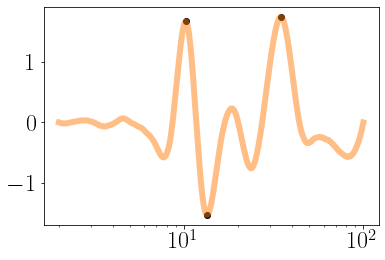

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:31<00:00,  9.60it/s]

0.9955929487179487 1.3289036544850499
0.0008012820512820513 0.0
0.0 0.0


In [30]:
# how often do the mock catalogs exclude zero perturbation to the same level as GWTC-3?

## GWTC-3: where are the maximum perturbations
### the 5th and 95th percentiles don't make much sense because their absolute values mean different things
### depending on if its an upwards or downwards pert
### the median and mean give almost the same results.
vals, locs = loc_max_extrema(np.percentile(gwtc_3_pert,50,axis=0),num_max=3)
print('The largest, second largest, and third largest-amplitude perturbations are at m_1 =',
      f'{ms[locs[0][-1]]:.1f}, {ms[locs[0][-2]]:.1f}, {ms[locs[0][-3]]:.1f} solar masses, respectively')

## GWTC-3: what percentage of posterior draws exclude zero at those points
exclude_zero_fracs_gwtc_3 = np.sum(gwtc_3_pert[:,locs] < 0,axis=0)/len(gwtc_3_pert)
print(f'We exclude zero at {np.flip(exclude_zero_fracs_gwtc_3)*100}% at those locations')

for l,f in zip(locs[0],exclude_zero_fracs_gwtc_3[0]):
     print(f'GWTC-3 excludes zero at {f*100:.3f}% at {ms[l]:.1f} solar masses.')

### validate
plt.plot(ms,np.percentile(gwtc_3_pert,50,axis=0), alpha=0.5, linewidth=6,color='tab:orange', label='GWTC-3')
plt.scatter(ms[locs], vals,c='k')
plt.xscale('log')
plt.show()


## mock catalogs: where is the maximum perturbation
exclude_zero_fracs = np.zeros(num_mock_catalogs)
for run in tqdm(range(num_mock_catalogs)):
    pert = perturbation_functions[f'run_{run}']
    vals_mock, locs_mock = loc_max_extrema(np.percentile(pert,50,axis=0),num_max=1)
    ## mock catalogs: what percentage of posterior draws exclude zero at those points
    exclude_zero_fracs[run] = np.sum(pert[:,locs_mock] <= 0,axis=0)/len(pert)

## compare    
compare_zero_fracs(exclude_zero_fracs_gwtc_3[0],exclude_zero_fracs)

Seems like none of the mock catalogs exclude zero at the same percentage as GWTC-3. Though I'm getting slightly more extreme values for these fractions than are in the GWTC-3 paper. Seems like that's because the values in the paper are evaluated at the locations 10, 15, and 35 exactly (see line 201 in `/home/daniel.wysocki/o3b-population-data/postproc_scripts/make_PowerLawSpline_macros.py`). We can try that too:

In [31]:
# how often do the mock catalogs exclude zero perturbation to the same level as GWTC-3?

## GWTC-3: where are the maximum perturbations
location_vals_gwtc_3 = [10,15,35]

def exclude_zero_at_value(pert,value):
    return np.sum(pert[:,np.isclose(ms,value,atol=0.1)].mean(axis=1) < 0)/(len(pert))

## GWTC-3: what percentage of posterior draws exclude zero at those points
exclude_zero_fracs_gwtc_3 =[]
for l in location_vals_gwtc_3: 
    f = exclude_zero_at_value(gwtc_3_pert,l)
    exclude_zero_fracs_gwtc_3.append(f)
    print(f'GWTC-3 excludes zero at {f*100:.3f}% at {l} solar masses.')

## mock catalogs: where is the maximum perturbation
exclude_zero_fracs = np.zeros(num_mock_catalogs)
for run in tqdm(range(num_mock_catalogs)):
    pert = perturbation_functions[f'run_{run}']
    vals_mock, locs_mock = loc_max_extrema(np.percentile(pert,50,axis=0),num_max=1)
    ## mock catalogs: what percentage of posterior draws exclude zero at those points
    exclude_zero_fracs[run] = np.sum(pert[:,locs_mock] < 0,axis=0)/len(pert)

compare_zero_fracs(exclude_zero_fracs_gwtc_3, exclude_zero_fracs)

GWTC-3 excludes zero at 0.096% at 10 solar masses.
GWTC-3 excludes zero at 94.247% at 15 solar masses.
GWTC-3 excludes zero at 0.000% at 35 solar masses.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:31<00:00,  9.43it/s]

0.0009615384615384616 0.0
0.9424679487179487 34.883720930232556
0.0 0.0


## Projections

Unfortuantely some artifacts appearing in the spline makes these runs unuseable, so we exclude projections from the paper.

With 500 event runs, errors will shrink, so the heights will probably decrease. 
But will things be less constrained away from zero?

### Full mock analysis
Could: take the characteristic width of the pert funcs in the mock catalogs, apply that to the current median value of the 14 solar mass dip, then run all the same analyses on that. 
~~This would be conservative since the 14 solar mass dip is more constrained than the mock catalogs.~~


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


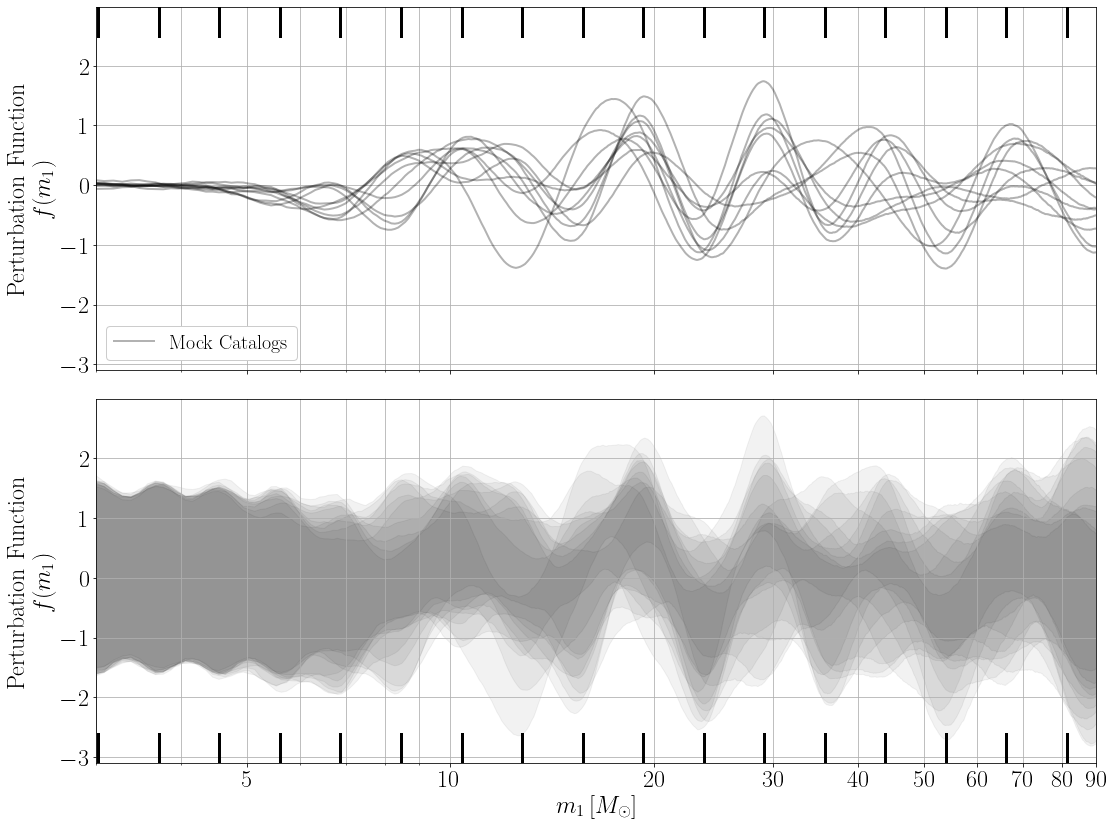

In [29]:
# load projection mock catalogs
fut_run_path = 'future_catalogs/'
fut_fnames = glob.glob(fut_run_path+'PowerLawSpline_138evs_20knots_2t100_*')
num_future_catalogs = len(fut_fnames)
num_knots = 20

future_perts = dict()
for run, fname in tqdm(enumerate(fut_fnames), total=num_future_catalogs):
    try:
        future_perts[f'run_{run}'], ms = get_perturbation(fname,exclude_mmin_mmax=False)
    except UnicodeDecodeError:
        print(fname)
        
##--------------------------------------
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(16,12), sharex=True, sharey=True)
for i in range(2):
    ax[i].set_ylabel('Perturbation Function\n$f(m_1)$')
    ax[i].grid(which = 'both',zorder=0)
for run in trange(10):
    pert = future_perts[f'run_{run}']
    low, med, high = np.percentile(pert, (5,50,95), axis=0)
    lab=None
    if run==9:
        lab='Mock Catalogs'
    ax[0].plot(ms,med,alpha=0.3,linewidth=2,color='k',label=lab)
    ax[1].fill_between(ms, low, high, alpha=0.05, color='k')
# knot locations
for m in m_spls_gwtc3:
    ax[0].axvline(m, alpha=1, color='k', ymin=.92,ymax=1,lw=3)
    ax[1].axvline(m, alpha=1, color='k', ymin=0,ymax=0.08,lw=3)
ax[0].legend(framealpha=1)
plt.xscale('log')
xticks = np.append([5],np.arange(start=1,stop=10,dtype=int)*10)
plt.xticks(xticks,labels=[f'{int(l)}' for l in xticks])
plt.xlim(3,90)
plt.xlabel('$m_1 \\,[M_\\odot]$')
plt.tight_layout()
plt.show()

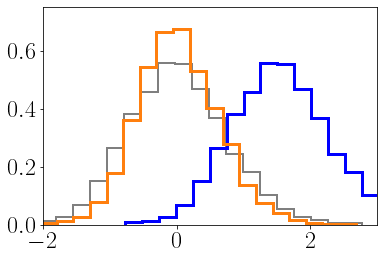

In [30]:
# create 14 dip from mock catalogs
vals, locs = loc_max_extrema(np.percentile(gwtc_3_pert,50,axis=0),num_max=3)
randind = np.random.randint(low=0,high=num_future_catalogs)
pert = future_perts[f'run_{randind}']
vals_mock, locs_mock = loc_max_extrema(np.percentile(pert,50,axis=0),num_max=1)
extrema = pert[:,locs_mock]
# if the majority of the distribution is negative, flip the whole thing about x=0
if np.sum(extrema<0) > len(extrema)/2:
    extrema = -1 * extrema.T
    vals_mock *= -1
else:
    extrema = extrema.T
demedianed_mock = extrema - vals_mock
demedianed_mock = demedianed_mock[0][0]
plt.hist(demedianed_mock, bins=20, histtype='step', lw=2, alpha=0.5, color='k', density=True)

projected_14_pert = -1*vals[0][0] + demedianed_mock
plt.hist(projected_14_pert, bins=20, histtype='step', lw=3, color='b', density=True)
plt.hist(-1*gwtc_3_pert[:,locs[0][0]]+vals[0][0],bins=20, histtype='step', lw=3,
         color='tab:orange', density=True)
plt.xlim(-2,3)
plt.ylim(0,.75)
plt.show()

-1.5270868021728807
---------------


  0%|                                                                                                                        | 0/36 [00:00<?, ?it/s]

1.484996505004812


  3%|███                                                                                                             | 1/36 [00:04<02:26,  4.18s/it]

0.9579882281024994


  6%|██████▏                                                                                                         | 2/36 [00:08<02:18,  4.09s/it]

1.2531644136141464


  8%|█████████▎                                                                                                      | 3/36 [00:12<02:14,  4.07s/it]

1.4422406882433014


 11%|████████████▍                                                                                                   | 4/36 [00:16<02:13,  4.18s/it]

1.0892840393860794


 14%|███████████████▌                                                                                                | 5/36 [00:20<02:10,  4.20s/it]

1.1449338191287421


 17%|██████████████████▋                                                                                             | 6/36 [00:24<02:04,  4.16s/it]

1.2075091639049051


 19%|█████████████████████▊                                                                                          | 7/36 [00:29<02:01,  4.19s/it]

1.7397633637673402


 22%|████████████████████████▉                                                                                       | 8/36 [00:33<01:57,  4.20s/it]

0.7993026784404277


 25%|████████████████████████████                                                                                    | 9/36 [00:37<01:53,  4.20s/it]

1.1633240825554412


 28%|██████████████████████████████▊                                                                                | 10/36 [00:41<01:50,  4.24s/it]

1.3248871256493897


 31%|█████████████████████████████████▉                                                                             | 11/36 [00:46<01:46,  4.26s/it]

0.9072424599849527


 33%|█████████████████████████████████████                                                                          | 12/36 [00:50<01:43,  4.29s/it]

1.1947759338826807


 36%|████████████████████████████████████████                                                                       | 13/36 [00:55<01:39,  4.34s/it]

0.9914867618471017


 39%|███████████████████████████████████████████▏                                                                   | 14/36 [00:59<01:35,  4.34s/it]

0.845420902924166


 42%|██████████████████████████████████████████████▎                                                                | 15/36 [01:03<01:30,  4.33s/it]

1.4525428763319972


 44%|█████████████████████████████████████████████████▎                                                             | 16/36 [01:08<01:27,  4.36s/it]

0.7931770870659453


 47%|████████████████████████████████████████████████████▍                                                          | 17/36 [01:12<01:22,  4.37s/it]

1.3367011523910386


 50%|███████████████████████████████████████████████████████▌                                                       | 18/36 [01:16<01:18,  4.37s/it]

1.431994400208926


 53%|██████████████████████████████████████████████████████████▌                                                    | 19/36 [01:21<01:14,  4.35s/it]

1.1048431155059661


 56%|█████████████████████████████████████████████████████████████▋                                                 | 20/36 [01:25<01:09,  4.32s/it]

1.214439979157426


 58%|████████████████████████████████████████████████████████████████▊                                              | 21/36 [01:29<01:04,  4.28s/it]

1.1696846513426051


 61%|███████████████████████████████████████████████████████████████████▊                                           | 22/36 [01:33<00:59,  4.24s/it]

1.787490376027423


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 23/36 [01:37<00:54,  4.23s/it]

1.0460292638094317


 67%|██████████████████████████████████████████████████████████████████████████                                     | 24/36 [01:42<00:50,  4.17s/it]

0.8488990718680193


 69%|█████████████████████████████████████████████████████████████████████████████                                  | 25/36 [01:46<00:45,  4.16s/it]

1.4134533100115465


 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 26/36 [01:50<00:42,  4.20s/it]

0.8710874751275817


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 27/36 [01:54<00:37,  4.17s/it]

0.8424754408164107


 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 28/36 [01:58<00:33,  4.14s/it]

1.2145634426161966


 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 29/36 [02:02<00:29,  4.17s/it]

1.096927760898157


 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 30/36 [02:07<00:25,  4.17s/it]

1.0296644140669542


 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 31/36 [02:11<00:20,  4.12s/it]

1.7188367156012017


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 32/36 [02:15<00:16,  4.10s/it]

0.7604044945448809


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 33/36 [02:19<00:12,  4.10s/it]

1.1457517398420864


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 34/36 [02:23<00:08,  4.15s/it]

1.462181541027268


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 35/36 [02:27<00:04,  4.17s/it]

1.513721676785772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [02:31<00:00,  4.22s/it]

1.0450039492762453 22.22222222222222


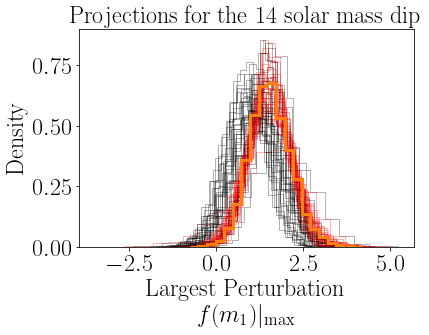

In [32]:
# exclude zero frac, averaged over demedianing with all mock cats
vals, locs = loc_max_extrema(np.percentile(gwtc_3_pert,50,axis=0),num_max=3)
print(vals[0][0])
print("---------------")
exclude_zero_fracs_gwtc4 =0
for run in trange(num_future_catalogs):
    pert = future_perts[f'run_{run}']
    vals_mock, locs_mock = loc_max_extrema(np.percentile(pert,50,axis=0),num_max=1)
    extrema = pert[:,locs_mock]
    # if the majority of the distribution is negative, flip the whole thing about x=0
    if np.sum(extrema<0) > len(extrema)/2:
        extrema = -1 * extrema.T
        vals_mock *= -1
    else:
        extrema = extrema.T
    plt.hist(extrema[0][0], bins=20, histtype='step', lw=1, alpha=0.3, color='k', density=True)
    demedianed_mock = extrema - vals_mock
    projected_14_pert = -1*vals[0][0] + demedianed_mock[0][0]
    plt.hist(projected_14_pert, bins=20, histtype='step', lw=1, alpha=0.3, color='r', density=True)
    print(vals_mock[0][0])
    
    future_exclude_zero_fracs = np.zeros(num_future_catalogs)
    for run in range(num_future_catalogs):
        pert = future_perts[f'run_{run}']
        vals_mock, locs_mock = loc_max_extrema(np.percentile(pert,50,axis=0),num_max=1)
        f = np.sum(pert[:,locs_mock] < 0,axis=0)/len(pert)
        if f >.5:
            f = 1-f
        future_exclude_zero_fracs[run] = f

    exclude_zero_fracs_gwtc4 += np.sum(projected_14_pert < 0,axis=0)/len(projected_14_pert)

exclude_zero_fracs_gwtc4 /= num_future_catalogs
print(exclude_zero_fracs_gwtc4*100,
      np.sum(future_exclude_zero_fracs<=exclude_zero_fracs_gwtc4)/num_future_catalogs*100)
plt.hist(-1*gwtc_3_pert[:,locs[0][0]],bins=20, histtype='step', lw=3,
         color='tab:orange', density=True)
plt.xlabel('Largest Perturbation \n $f(m_1)|_{\mathrm{max}}$')
plt.ylabel('Density')
plt.title('Projections for the 14 solar mass dip')
plt.show()

### injections

We found 49604 injections out of 284672.
We found 49242 injections out of 284672.
bins are:  [ 9.43132817 13.53701677 17.64270537 21.74839398 25.85408258 29.95977118
 34.06545978 38.17114838 42.27683699 46.38252559 50.48821419 54.59390279
 58.69959139 62.80528    66.9109686  71.0166572  75.1223458  79.2280344
 83.33372301 87.43941161 91.54510021]
for $\alpha=3.25$, [0.2  0.   0.   0.22 0.   0.84 1.   1.   0.88 0.76 0.79 0.06 0.7  0.18
 0.96 0.   0.   0.   0.   0.86]% are less than observations
for $\alpha=2.7$, [0.99 0.   0.01 0.53 0.   0.73 1.   1.   0.69 0.34 0.35 0.   0.18 0.01
 0.52 0.   0.   0.   0.   0.46]% are less than observations


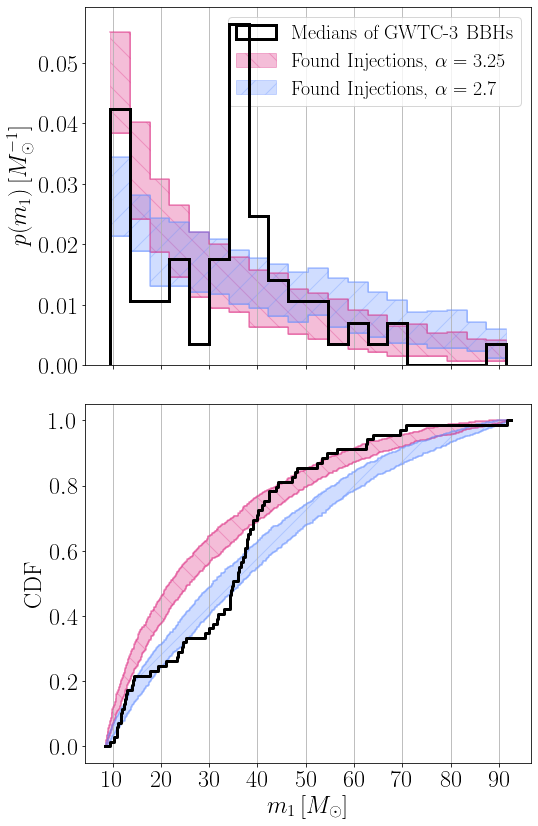

In [105]:
# construct predicted events
num_realizations=int(1e2)
resampled_injs = change_pdraw(filename, alpha=-2.7, mmin=mmin, mmax=92, plot=False)
found_injs_27 = find_injections(resampled_injs)
resampled_injs = change_pdraw(filename, alpha=-3.25, mmin=mmin, mmax=92, plot=False)
found_injs_314 = find_injections(resampled_injs)
drawn_events_27 = np.random.choice(found_injs_27,size=(500,num_realizations))
drawn_events_314 = np.random.choice(found_injs_314,size=(500,num_realizations))
# construct predicted CDFs
m_space = np.linspace(np.min(medians)-1,np.max(medians)+1,num=500)
inj_cdfs_27 = np.zeros((num_realizations,len(m_space)))
inj_cdfs_314 = np.zeros((num_realizations,len(m_space)))
for i in range(num_realizations):
    inj_cdfs_27[i] = plot_edf(drawn_events_27[:,i],x_ax=m_space,plot=False)
    inj_cdfs_314[i] = plot_edf(drawn_events_314[:,i],x_ax=m_space,plot=False)

    
# plot

fig, ax = plt.subplots(figsize=(8,12),nrows=2,ncols=1,sharex=True)

bins, rhi314, rhi27 = make_multi_histogram_plot(medians,drawn_events_314,drawn_events_27,
                                                bins=20, ax=ax[0], return_pvals=True,
                                                lab1='$\\alpha=3.25$',lab2='$\\alpha=2.7$'
                                               )
ax[0].grid(which='both', axis='x',zorder=0)

plot_edf(medians, x_ax=m_space,ax=ax[1], label='Medians of GWTC-3 BBHs',color='k',zorder=50,linewidth=3)##FFB000

plt.fill_between(m_space, np.percentile(inj_cdfs_314, 5, axis=0), np.percentile(inj_cdfs_314, 95, axis=0),
                 step='post', alpha=0.3, color='#DC267F',
                 hatch='\\', label='Found injections, $\\alpha=3.25$')
# hatching bug workaround
# plt.fill_between(m_space, np.percentile(inj_cdfs_314, 5, axis=0), np.percentile(inj_cdfs_314, 95, axis=0),
#                  step='post', alpha=0.3, color='None', edgecolor='#DC267F', linewidth=2,hatch='\\')
# add edges
plt.plot(m_space, np.percentile(inj_cdfs_314, 5, axis=0),
                 drawstyle='steps-post', alpha=0.5, color='#DC267F')
plt.plot(m_space, np.percentile(inj_cdfs_314, 95, axis=0),
                 drawstyle='steps-post', alpha=0.5, color='#DC267F')

plt.fill_between(m_space, np.percentile(inj_cdfs_27, 5, axis=0), np.percentile(inj_cdfs_27, 95, axis=0),
                 step='post', alpha=0.3, color='#648FFF', hatch='/', label='Found injections, $\\alpha=2.7$')
plt.plot(m_space, np.percentile(inj_cdfs_27, 5, axis=0),
                 drawstyle='steps-post', alpha=0.5, color='#648FFF')
plt.plot(m_space, np.percentile(inj_cdfs_27, 95, axis=0),
                 drawstyle='steps-post', alpha=0.5, color='#648FFF')


plt.grid(which='both', axis='x',zorder=0)
# plt.legend(fontsize=20)
# plt.annotate(f'Power Law with $\\alpha=${a}',xy=(50,0.5),fontsize=20)
plt.xlabel('$m_1\,[M_\\odot]$')
plt.xticks(range(10,100,10))
plt.ylabel('CDF')
plt.tight_layout()
# plt.savefig('figures/point_estimate_observed_plaw_20_bins_and_CDF.pdf')
# plt.savefig('figures/hatching_test.pdf')
plt.show()

In [170]:
print("For alpha=3.25")
idxs = most_sig_3(rhi314)    
for idx in idxs:
    print(f"The bin centered on: {np.mean([bins[idx],bins[idx+1]]):.1f} has r_h^i = {rhi314[idx]}")
    
print("For alpha=2.7")
idxs = most_sig_3(rhi27)
for idx in idxs:
    print(f"The bin centered on: {np.mean([bins[idx],bins[idx+1]]):.1f} has r_h^i = {rhi27[idx]}")

For alpha=3.25
The bin centered on: 36.1 has r_h^i = 1.0
The bin centered on: 40.2 has r_h^i = 1.0
The bin centered on: 69.0 has r_h^i = 0.96
For alpha=2.7
The bin centered on: 36.1 has r_h^i = 1.0
The bin centered on: 40.2 has r_h^i = 1.0
The bin centered on: 11.5 has r_h^i = 0.99


## Appendix

In [32]:
qgrid = np.linspace(0,1)
m1, q = np.meshgrid(mgrid,qgrid)
m = Model([SinglePeakSmoothedMassDistribution()])
inj_params = dict(
        alpha=3.14,
        alpha_1=3.14,
        alpha_2=3.14,
        mmin=4.56,
        delta_m=5.96,
        lam=0.0,
        mpp=35.,
        sigpp=5.,
        mmax=81.08,
        beta=1.70,
        lamb=2.7,
        break_fraction=0.5,
    ) 
m.parameters.update(inj_params)
inj = m.prob({'mass_1':m1,'mass_ratio':q})

/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/models/mass.py:618: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)
/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/models/mass.py:557: RuntimeWarning: invalid value encountered in true_divide
  p_q /= self.norm_p_q(beta=beta, mmin=mmin, delta_m=delta_m)


  0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/models/mass.py:554: RuntimeWarning: invalid value encountered in true_divide
  p_q /= self.norm_p_q(beta=beta, mmin=mmin, delta_m=delta_m)
/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/utils.py:77: RuntimeWarning: divide by zero encountered in power
  prob = xp.power(xx, alpha)
/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/utils.py:79: RuntimeWarning: invalid value encountered in multiply
  prob *= (xx <= high) & (xx >= low)
 10%|███████████                                                                                                    | 1/10 [00:26<04:02, 26.93s/it]/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/models/mass.py:618: Runti

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [03:40<00:24, 24.02s/it]/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/models/mass.py:618: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)
/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/models/mass.py:554: RuntimeWarning: invalid value encountered in true_divide
  p_q /= self.norm_p_q(beta=beta, mmin=mmin, delta_m=delta_m)
/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/utils.py:77: RuntimeWarning: divide by zero encountered in power
  prob = xp.power(xx, alpha)
/Users/amandafarah/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpopulation/utils.py:79: RuntimeWarning: invalid value encountered in multiply
  prob *= (xx <= high) & (xx >= low)
100%|███████████████████████████████████████████████

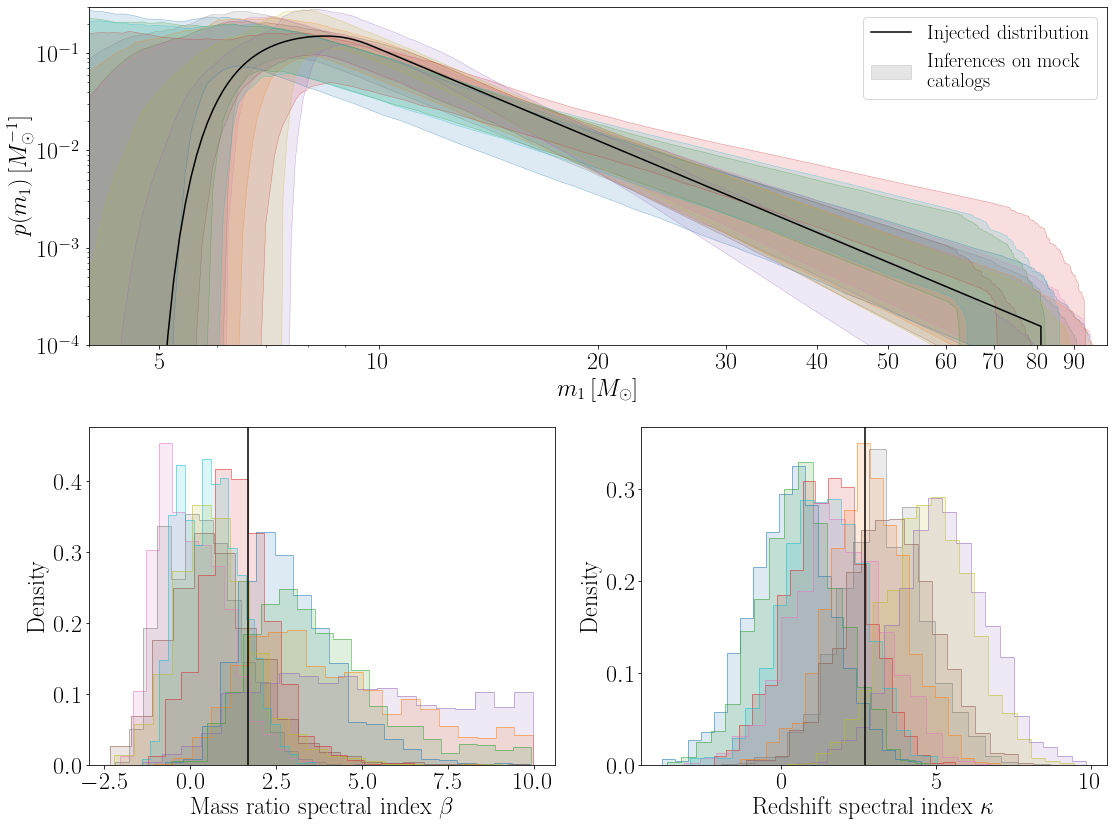

In [33]:
fig, axes = plt.subplot_mosaic("AA;BC", figsize=(16,12),
                               #gridspec_kw=dict(wspace=0.2,hspace=0.3),
                              )
debug_run_path = 'z_debugging/'
m = Model([SinglePeakSmoothedMassDistribution()])
num_samps = 1000
qgrid = np.linspace(0,1)
m1, q = np.meshgrid(mgrid,qgrid)
p_m1 = np.zeros((num_samps,len(mgrid)))
p_q = np.zeros((num_samps,50))
for i in trange(10):
#     if i==3:
#         continue
    t_post = load_result_json(mock_run_path+f'Truncated_69evs_{i+1}_result.json')
#     t_post = load_result_json(debug_run_path+f'newest_PE_2_{i}_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json')
    t_post = pd.DataFrame(t_post)
    for j in range(num_samps):
        m.parameters.update(t_post.iloc[j])
        prob = m.prob({'mass_1':m1,'mass_ratio':q})
        p_m1[j] = np.trapz(prob,q,axis=0)
#         p_q[j] = np.trapz(prob,m1,axis=1)
    p=axes['A'].fill_between(mgrid,*np.percentile(p_m1,[5,95],axis=0),alpha=0.15)
    c=p.get_facecolor()
    axes['A'].plot(mgrid,np.percentile(p_m1,[5,95],axis=0).T,alpha=0.5,lw=0.5,color=c)
    axes['B'].hist(t_post['beta'],bins=20,density=True,alpha=0.15)
    axes['B'].hist(t_post['beta'],bins=20,density=True,histtype='step',alpha=0.5,color=c)
    axes['C'].hist(t_post['lamb'],bins=20,density=True,alpha=0.15)
    axes['C'].hist(t_post['lamb'],bins=20,density=True,histtype='step',alpha=0.5,color=c)
#     axes['B'].fill_between(qgrid,*np.percentile(p_q,[5,95],axis=0),alpha=0.15)
#     axes['C'].fill_between(qgrid,*np.percentile(p_q,[5,95],axis=0),alpha=0.15)


l_inj, = axes['A'].plot(mgrid,np.trapz(inj,q,axis=0),c='k')
axes['A'].set_ylim(1e-4,3e-1)
axes['A'].set_xlim(4,100)
axes['A'].set_xscale('log')
xticks = np.append([5],np.arange(start=1,stop=10,dtype=int)*10)
axes['A'].set_xticks(xticks)
axes['A'].set_xticklabels([f'{int(l)}' for l in xticks])
axes['A'].set_yscale('log')
l_fit = mpatches.Patch(alpha=0.2,facecolor='grey',edgecolor='k',lw=0.5)
axes['A'].legend((l_inj,l_fit),('Injected distribution','Inferences on mock\ncatalogs'))
axes['A'].set_xlabel('$m_1\, [M_\odot]$')
axes['A'].set_ylabel('$p(m_1)\, [M_\odot^{-1}]$')

# axes['B'].plot(qgrid,np.trapz(inj,m1,axis=1),c='k')
# axes['B'].set_yscale('log')
# axes['B'].set_xlabel('$q$')
# axes['B'].set_ylabel('$p(q)$')
axes['B'].axvline(inj_params['beta'],c='k')
axes['B'].set_xlabel('Mass ratio spectral index $\\beta$')
axes['B'].set_ylabel('Density')

# axes['C'].plot(qgrid,np.trapz(inj,m1,axis=1),c='k')
# axes['C'].set_xlabel('$z$')
# axes['C'].set_ylabel('$p(z)$')
axes['C'].axvline(inj_params['lamb'],c='k')
axes['C'].set_xlabel('Redshift spectral index $\\kappa$')
axes['C'].set_ylabel('Density')

fig.tight_layout()
plt.savefig('figures/MDC_pdfs.pdf')
plt.show()

In [34]:
# How often do the injected hyperparameters fall within the recovered 90% CIs?
inj_df=pd.DataFrame(inj_params,index=[1])

inferred_params = ['alpha','mmin','delta_m','mmax','beta','lamb']
within=inj_df[inferred_params].copy()

truncated_fnames = glob.glob(mock_run_path+'Truncated_*')
# truncated_fnames = glob.glob(debug_run_path+f'newest_PE_2_*_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json')
# note that the new_PE used the same injection set as the z_norm runs
num_t_fits = len(truncated_fnames)
for f in tqdm(truncated_fnames,total=num_t_fits):
    t_post = load_result_json(f)
    t_post = pd.DataFrame(t_post)
    within=pd.concat([within,
               (inj_df[inferred_params]<t_post[inferred_params].quantile(.95))
               *(inj_df[inferred_params]>t_post[inferred_params].quantile(.05))],
             )#.mean('columns')
# for k in inferred_params:
#     p5,p95=np.percentile(t_post[k],[5,95])
#     within += p5<inj_params[k]<p95
# print(within/len(inferred_params))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:41<00:00,  2.41it/s]


In [36]:
within.reset_index().drop(0,axis='index').mean().drop('index').mean()

0.896039603960396